# Imports

In [1]:
!pip install -q mplcyberpunk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.datasets import macrodata
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import mplcyberpunk as mcp
from itertools import product

plt.style.use('cyberpunk')

# Load Data

In [3]:
# Load the data
data = macrodata.load_pandas().data
display(data)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [4]:
# Print info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


# Clean Data

In [5]:
# Preprocess the data
data['month'] = (data['quarter'] - 1) * 3 + 1
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

# Set the index to quarterly periods
data.set_index('date', inplace=True)
data.index = data.index.to_period('Q')
print('Preprocessed Data:')
display(data)

# Define y and X
y = data['realgdp']
X = data[['realcons', 'realinv']]

# Print shapes
print(f'\ny shape: {y.shape}')
print(f'X shape: {X.shape}')

Preprocessed Data:


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,month
date,,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1.0
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,4.0
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,7.0
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,10.0
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,7.0
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,10.0
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,1.0



y shape: (203,)
X shape: (203, 2)


In [6]:
# Display data
print('\ny Data:')
display(y)
print('\nX Data:')
display(X)


y Data:


,realgdp
date,
1959Q1,2710.349
1959Q2,2778.801
1959Q3,2775.488
1959Q4,2785.204
1960Q1,2847.699
...,...
2008Q3,13324.600
2008Q4,13141.920
2009Q1,12925.410



X Data:


,realcons,realinv
date,,
1959Q1,1707.4,286.898
1959Q2,1733.7,310.859
1959Q3,1751.8,289.226
1959Q4,1753.7,299.356
1960Q1,1770.5,331.722
...,...,...
2008Q3,9267.7,1990.693
2008Q4,9195.3,1857.661
2009Q1,9209.2,1558.494


In [7]:
# Print info
print('y Data:')
y.info()
print('\nX Data:')
X.info()

y Data:
<class 'pandas.core.series.Series'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
203 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB

X Data:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  203 non-null    float64
 1   realinv   203 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


# Split Data

In [8]:
# Split the data
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Print shapes
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'\nX_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

y_train shape: (162,)
y_test shape: (41,)

X_train shape: (162, 2)
X_test shape: (41, 2)


In [9]:
# Print info
print('y_train info:')
y_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_train info:')
X_train.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

# Forecasting

In [10]:
# Initialize a dictionary to store forecasts
forecasts = {}

## Exponential Smoothing

In [11]:
# Simple Exponential Smoothing
model_ses = ExponentialSmoothing(y_train).fit()
forecast_ses = model_ses.forecast(len(y_test))
forecasts['Simple ES'] = forecast_ses

# Double Exponential Smoothing (Holt's linear trend model)
model_des = ExponentialSmoothing(y_train, trend='add').fit()
forecast_des = model_des.forecast(len(y_test))
forecasts['Double ES'] = forecast_des

# Triple Exponential Smoothing (Holt-Winters seasonal model)
model_tes = ExponentialSmoothing(y_train, seasonal_periods=4, trend='add', seasonal='add').fit()
forecast_tes = model_tes.forecast(len(y_test))
forecasts['Triple ES'] = forecast_tes

## ARIMA & SARIMAX

In [12]:
# ARIMA
model_arima = ARIMA(y_train, order=(2, 1, 1)).fit()
forecast_arima = model_arima.forecast(len(y_test))
forecasts['ARIMA'] = forecast_arima

# SARIMAX
model_sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4), exog=X_train).fit()
forecast_sarimax = model_sarimax.forecast(len(y_test), exog=X_test)
forecasts['SARIMAX'] = forecast_sarimax

## Vector Autoregression

In [13]:
# VAR
data_var = pd.concat([y_train, X_train], axis=1)
model_var = VAR(data_var)
model_var_fit = model_var.fit(maxlags=15, ic='aic')
lag_order = model_var_fit.k_ar
forecast_input = data_var.values[-lag_order:]
forecast_var = model_var_fit.forecast(y=forecast_input, steps=len(y_test))
forecast_var_df = pd.DataFrame(forecast_var, index=y_test.index, columns=[y.name] + list(X.columns))
forecast_var_y = forecast_var_df[y.name]
forecasts['VAR'] = forecast_var_y

# Plotting

In [14]:
# Function to convert index
def convert_index(data_list, to_index_type='datetime', freq=None):
    """
    Converts the index of each DataFrame or Series in a list to a PeriodIndex or DatetimeIndex.

    Parameters:
    - data_list (list): A list of Pandas DataFrames or Series.
    - to_index_type (str): The type of index to convert to. Options are 'datetime' or 'period'.
    - freq (str, optional): The frequency to use for conversion to PeriodIndex. If None, it will try to infer from the data.

    Returns:
    - list: A list of DataFrames or Series with the converted indices.
    """

    if not isinstance(data_list, list):
        raise TypeError("Input must be a list of Pandas DataFrames or Series.")

    converted_list = []
    for df_or_series in data_list:
        if not isinstance(df_or_series, (pd.DataFrame, pd.Series)):
            raise TypeError("Each item in the list must be a Pandas DataFrame or Series.")

        current_index = df_or_series.index

        if to_index_type == 'datetime':
            if isinstance(current_index, pd.DatetimeIndex):
                # Already a DatetimeIndex, no conversion needed
                converted_list.append(df_or_series)
            elif isinstance(current_index, pd.PeriodIndex):
                # Convert PeriodIndex to DatetimeIndex
                df_or_series.index = current_index.to_timestamp()
                converted_list.append(df_or_series)
            else:
                # Convert to DatetimeIndex
                df_or_series.index = pd.to_datetime(current_index)
                converted_list.append(df_or_series)
        elif to_index_type == 'period':
            if isinstance(current_index, pd.PeriodIndex):
                # Already a PeriodIndex, no conversion needed
                converted_list.append(df_or_series)
            else:
                # Try to infer the frequency if not provided
                inferred_freq = current_index.inferred_freq if freq is None else freq

                # Simplify or handle specific complex frequencies
                if inferred_freq is None:
                    raise ValueError("Frequency 'freq' must be provided or inferred from the data.")
                elif 'Q' in inferred_freq.upper():
                    inferred_freq = 'Q'
                elif 'M' in inferred_freq.upper():
                    inferred_freq = 'M'
                elif 'W' in inferred_freq.upper():
                    inferred_freq = 'W'
                elif 'D' in inferred_freq.upper():
                    inferred_freq = 'D'
                else:
                    raise ValueError(f"Unsupported or complex frequency '{inferred_freq}'. Please provide a compatible frequency.")

                # Convert to PeriodIndex using inferred or provided freq
                df_or_series.index = current_index.to_period(inferred_freq)
                converted_list.append(df_or_series)
        else:
            raise ValueError("Invalid index type specified. Use 'datetime' or 'period'.")

    return converted_list

In [15]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

In [16]:
# Convert index to DatetimeIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='datetime')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 162 entries, 1959-01-01 to 1999-04-01
Freq: QS-OCT
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 1959-01-01 to 1999-04-01
Freq: QS-OCT
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 41 entries, 1999-07-01 to 2009-07-01
Freq: QS-OCT
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 1999-07-01 to 2009-07-01
Freq: QS-OCT
Data columns (total 2 columns):
 #

In [17]:
# Define a neon color map for each model
colors = {
    'Train': '#08F7FE',      # neon cyan
    'Actual': 'white',       # white
    'Simple ES': '#F5D300',  # neon yellow
    'Double ES': '#00ff41',  # neon green
    'Triple ES': '#FF5733',  # neon orange
    'ARIMA': '#FF073A',      # neon red
    'SARIMAX': '#FF00FF',    # neon pink
    'VAR': '#8900FF'         # neon purple
}

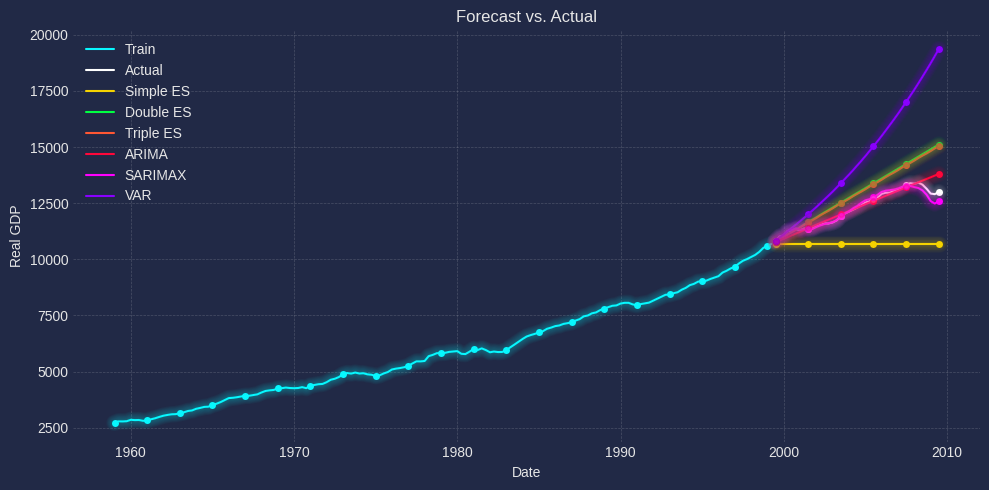

In [18]:
# Define the plot figure
plt.figure(figsize=(10, 5))

# Plot the train data with markers every 8th point
plt.plot(y_train.index, y_train, label='Train', color=colors['Train'], linestyle='-')
plt.plot(y_train.index[::8], y_train[::8], label='_nolegend_', color=colors['Train'], linestyle='None', marker='o', markersize=4)

# Plot the actual data with markers every 8th point
plt.plot(y_test.index, y_test, label='Actual', color=colors['Actual'], linestyle='-')
plt.plot(y_test.index[::8], y_test[::8], label='_nolegend_', color=colors['Actual'], linestyle='None', marker='o', markersize=4)

# Plot the forecast data with markers every 8th point
for model_name, forecast in forecasts.items():
    if isinstance(forecast.index, pd.PeriodIndex):
        forecast.index = forecast.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex if necessary
    plt.plot(y_test.index, forecast, label=model_name, color=colors[model_name], linestyle='-')
    plt.plot(y_test.index[::8], forecast[::8], label='_nolegend_', color=colors[model_name], linestyle='None', marker='o', markersize=4)

plt.xlabel('Date')
plt.ylabel('Real GDP')
plt.legend(loc='upper left')
plt.title('Forecast vs. Actual')
plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
plt.tight_layout()
mcp.make_lines_glow()
plt.show()

# Metrics

In [19]:
!pip install -q sktime dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 1.8 MB/s eta 0:00:00


In [20]:
# Function to calculate the symmetric mean absolute percentage error
def custom_symmetric_mean_absolute_percentage_error(y_true, y_pred, multioutput="uniform_average"):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (sMAPE).

    sMAPE is a measure of forecast accuracy, expressed as a percentage.
    It is symmetric, meaning it treats overestimates and underestimates equally.

    Parameters:
    - y_true: np.array, pd.Series, or pd.DataFrame
        Actual values. Supports 1D or 2D arrays.
    - y_pred: np.array, pd.Series, or pd.DataFrame
        Predicted values. Supports 1D or 2D arrays.
    - multioutput: {'raw_values', 'uniform_average'} or array-like, default='uniform_average'
        Defines how to aggregate metric for multivariate data.
        If 'raw_values', returns sMAPE for each output separately.
        If 'uniform_average', returns the average sMAPE of all outputs.
        If array-like, weights are used to average the errors.

    Returns:
    - smape: float, np.array, or pd.Series
        The symmetric mean absolute percentage error.
        If the input is a 2D array or DataFrame and `multioutput='raw_values'`,
        it returns a Series with sMAPE for each column.
    """

    # Convert inputs to NumPy arrays for consistent processing
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Define a small epsilon to prevent division by zero
    EPS = np.finfo(float).eps

    # Calculate the symmetric percentage error
    percentage_error = 2 * np.abs(y_true - y_pred) / np.maximum(np.abs(y_true) + np.abs(y_pred), EPS)

    # Calculate the mean of the percentage errors along the appropriate axis
    smape = np.mean(percentage_error, axis=0)

    # Handle multioutput aggregation
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return smape
        elif multioutput == "uniform_average":
            return np.mean(smape)
    else:
        # Apply custom weights
        if len(multioutput) != len(smape):
            raise ValueError("Length of weights must match the number of outputs.")
        return np.average(smape, weights=multioutput)

    return smape

In [21]:
# Function to calculate the mean absolute scaled error
def custom_mean_absolute_scaled_error(y_true, y_pred, y_train, sp=1, multioutput="uniform_average"):
    """
    Calculate the Mean Absolute Scaled Error (MASE).

    MASE compares forecast errors against a naive seasonal forecast, making it
    a scale-free metric useful for comparing accuracy across different series.

    Parameters:
    - y_true: np.array, pd.Series, or pd.DataFrame
        Actual values. Supports 1D or 2D arrays.
    - y_pred: np.array, pd.Series, or pd.DataFrame
        Predicted values. Supports 1D or 2D arrays.
    - y_train: np.array, pd.Series, or pd.DataFrame
        Training data used for scaling. Supports 1D or 2D arrays.
    - sp: int, default=1
        Seasonal periodicity of the data.
    - multioutput: {'raw_values', 'uniform_average'} or array-like, default='uniform_average'
        Defines how to aggregate metric for multivariate data.
        If 'raw_values', returns MASE for each output separately.
        If 'uniform_average', returns the average MASE of all outputs.
        If array-like, weights are used to average the errors.

    Returns:
    - mase: float, np.array, or pd.Series
        The Mean Absolute Scaled Error.
        If the input is a 2D array or DataFrame and `multioutput='raw_values'`,
        it returns a Series with MASE for each column.
    """

    # Convert inputs to NumPy arrays for consistent processing
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # Ensure y_train is at least 2D for consistent dimensionality
    if y_train.ndim == 1:
        y_train = np.expand_dims(y_train, axis=1)

    # Compute the naive seasonal forecast
    y_pred_naive = y_train[:-sp]

    # Compute the Mean Absolute Error of the naive forecast
    mae_naive = mean_absolute_error(y_train[sp:], y_pred_naive, multioutput="raw_values")

    # Compute the Mean Absolute Error of the predictions
    mae_pred = mean_absolute_error(y_true, y_pred, multioutput="raw_values")

    # Define a small epsilon to prevent division by zero
    EPS = np.finfo(float).eps

    # Calculate MASE
    mase = mae_pred / np.maximum(mae_naive, EPS)

    # Handle multioutput aggregation
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return mase
        elif multioutput == "uniform_average":
            return np.mean(mase)
    else:
        # If custom weights are provided, apply them correctly
        if isinstance(mase, np.ndarray) and mase.ndim > 0:
            if len(multioutput) != len(mase):
                raise ValueError("Length of weights must match number of outputs.")
            return np.dot(mase, multioutput) / np.sum(multioutput)
        else:
            # Handle case where there is a single output
            return mase

    return mase

In [22]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_percentage_error

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred, sp=4, y_train=y_train)
    mase_custom = custom_mean_absolute_scaled_error(y_true, y_pred, sp=4, y_train=y_train)
    mape = mean_absolute_percentage_error(y_true, y_pred, symmetric=False)
    smape = mean_absolute_percentage_error(y_true, y_pred, symmetric=True)
    smape_custom = custom_symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, mase, mase_custom, mape, smape, smape_custom

metrics = ['MSE', 'RMSE', 'MAE', 'MASE', 'Custom MASE', 'MAPE', 'sMAPE', 'Custom sMAPE']
results = {}

for model_name, forecast in forecasts.items():
    results[model_name] = calculate_metrics(y_test, forecast, y_train)

In [23]:
# Create a DataFrame for the results
results_df = pd.DataFrame(results, index=metrics).T
results_df.index.name = 'Model'

styled_results_df = results_df.style.set_table_styles(
    [{'selector': 'th.col0', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
     {'selector': 'th', 'props': [('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'}).format(precision=3)

# Highlight the lowest value in each column
styled_results_df = styled_results_df.highlight_min(color='lightgreen', axis=0)
display(styled_results_df)

,MSE,RMSE,MAE,MASE,Custom MASE,MAPE,sMAPE,Custom sMAPE
Model,,,,,,,,
Simple ES,3107463.527,1762.800,1567.521,7.422,7.422,0.124,0.134,0.134
Double ES,788281.044,887.852,718.887,3.404,3.404,0.057,0.054,0.054
Triple ES,716406.507,846.408,683.030,3.234,3.234,0.054,0.052,0.052
ARIMA,61717.295,248.430,152.533,0.722,0.722,0.012,0.012,0.012
SARIMAX,19183.402,138.504,88.099,0.417,0.417,0.007,0.007,0.007
VAR,8184379.977,2860.836,2250.676,10.657,10.657,0.176,0.155,0.155


# Tuning

In [24]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

In [25]:
# Initialize a dictionary to store forecasts
forecasts = {}

## TES

In [26]:
# Define parameter grid
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [2, 4, 8]
}

# Initialize variables to store the best parameters and the best MAPE
best_mape = float('inf')
best_params = None

# Check data integrity before tuning
assert y_train.isna().sum() == 0, "y_train contains NaN values."
assert len(y_train) > 0, "y_train is empty."

# Perform a manual grid search
print("Performing grid search...")
for trend, seasonal, seasonal_periods in product(param_grid['trend'], param_grid['seasonal'], param_grid['seasonal_periods']):
    if seasonal is None or len(y_train) < 2 * seasonal_periods:  # Skip invalid or infeasible combinations
        print(f"\n\nSkipping Trend={trend}, Seasonal={seasonal}, Seasonal Periods={seasonal_periods}: insufficient data length.")
        continue

    try:
        print(f"\n\nTesting Trend={trend}, Seasonal={seasonal}, Seasonal Periods={seasonal_periods}")
        model = ExponentialSmoothing(y_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
        forecast = model.forecast(len(y_test))

        mape = mean_absolute_percentage_error(y_test, forecast)
        print(f"Test MAPE={mape:.3f}")

        if mape < best_mape:
            best_mape = mape
            best_params = (trend, seasonal, seasonal_periods)
            print(f"New best model: Trend={trend}, Seasonal={seasonal}, Seasonal Periods={seasonal_periods} with MAPE={mape:.3f}")

    except Exception as e:
        print(f"\nError with Trend={trend}, Seasonal={seasonal}, Seasonal Periods={seasonal_periods}: {e}")
        continue

# Train final model with the best parameters
if best_params:
    best_trend, best_seasonal, best_seasonal_periods = best_params
    print(f"\n\nBest parameters for Exponential Smoothing: Trend={best_trend}, Seasonal={best_seasonal}, Seasonal Periods={best_seasonal_periods}")
    model_es = ExponentialSmoothing(y_train, trend=best_trend, seasonal=best_seasonal, seasonal_periods=best_seasonal_periods).fit()
    forecast_es = model_es.forecast(len(y_test))
    forecasts['TES'] = forecast_es
else:
    print("No valid parameter combination was found.")

Performing grid search...


Testing Trend=add, Seasonal=add, Seasonal Periods=2
Test MAPE=0.057
New best model: Trend=add, Seasonal=add, Seasonal Periods=2 with MAPE=0.057


Testing Trend=add, Seasonal=add, Seasonal Periods=4
Test MAPE=0.054
New best model: Trend=add, Seasonal=add, Seasonal Periods=4 with MAPE=0.054


Testing Trend=add, Seasonal=add, Seasonal Periods=8
Test MAPE=0.061


Testing Trend=add, Seasonal=mul, Seasonal Periods=2
Test MAPE=0.056


Testing Trend=add, Seasonal=mul, Seasonal Periods=4
Test MAPE=0.054
New best model: Trend=add, Seasonal=mul, Seasonal Periods=4 with MAPE=0.054


Testing Trend=add, Seasonal=mul, Seasonal Periods=8
Test MAPE=0.051
New best model: Trend=add, Seasonal=mul, Seasonal Periods=8 with MAPE=0.051


Testing Trend=mul, Seasonal=add, Seasonal Periods=2
Test MAPE=0.093


Testing Trend=mul, Seasonal=add, Seasonal Periods=4
Test MAPE=0.090


Testing Trend=mul, Seasonal=add, Seasonal Periods=8


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Test MAPE=0.101


Testing Trend=mul, Seasonal=mul, Seasonal Periods=2
Test MAPE=0.091


Testing Trend=mul, Seasonal=mul, Seasonal Periods=4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Test MAPE=0.090


Testing Trend=mul, Seasonal=mul, Seasonal Periods=8


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Test MAPE=0.053


Best parameters for Exponential Smoothing: Trend=add, Seasonal=mul, Seasonal Periods=8


## ARIMA

In [27]:
# Define parameter grid for ARIMA
p = range(0, 5)
d = range(0, 2)
q = range(0, 3)

param_grid = list(product(p, d, q))

best_mape = float('inf')
best_arima_order = None

# Check data integrity before tuning
assert y_train.isna().sum() == 0, "y_train contains NaN values."
assert len(y_train) > 0, "y_train is empty."

# Perform a manual grid search
print("Performing grid search...")
for order in param_grid:
    try:
        print(f"\n\nTesting ARIMA order={order}")
        model = ARIMA(y_train, order=order).fit()
        forecast = model.forecast(len(y_test))

        mape = mean_absolute_percentage_error(y_test, forecast)
        print(f"Test MAPE={mape:.3f}")

        if mape < best_mape:
            best_mape = mape
            best_arima_order = order
            print(f"New best model: ARIMA order={order} with MAPE={mape:.3f}")

    except Exception as e:
        print(f"Error with ARIMA order={order}: {e}")
        continue

# Train final model with the best parameters
if best_arima_order:
    print(f"\n\nBest ARIMA order={best_arima_order}")
    model_arima = ARIMA(y_train, order=best_arima_order).fit()
    forecast_arima = model_arima.forecast(len(y_test))
    forecasts['ARIMA'] = forecast_arima
else:
    print("\n\nNo valid ARIMA order was found.")

Performing grid search...


Testing ARIMA order=(0, 0, 0)
Test MAPE=0.512
New best model: ARIMA order=(0, 0, 0) with MAPE=0.512


Testing ARIMA order=(0, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.507
New best model: ARIMA order=(0, 0, 1) with MAPE=0.507


Testing ARIMA order=(0, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.502
New best model: ARIMA order=(0, 0, 2) with MAPE=0.502


Testing ARIMA order=(0, 1, 0)
Test MAPE=0.124
New best model: ARIMA order=(0, 1, 0) with MAPE=0.124


Testing ARIMA order=(0, 1, 1)
Test MAPE=0.122
New best model: ARIMA order=(0, 1, 1) with MAPE=0.122


Testing ARIMA order=(0, 1, 2)
Test MAPE=0.121
New best model: ARIMA order=(0, 1, 2) with MAPE=0.121


Testing ARIMA order=(1, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.125


Testing ARIMA order=(1, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.123


Testing ARIMA order=(1, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.124


Testing ARIMA order=(1, 1, 0)
Test MAPE=0.110
New best model: ARIMA order=(1, 1, 0) with MAPE=0.110


Testing ARIMA order=(1, 1, 1)
Test MAPE=0.031
New best model: ARIMA order=(1, 1, 1) with MAPE=0.031


Testing ARIMA order=(1, 1, 2)
Test MAPE=0.023
New best model: ARIMA order=(1, 1, 2) with MAPE=0.023


Testing ARIMA order=(2, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.117


Testing ARIMA order=(2, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.065


Testing ARIMA order=(2, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.126


Testing ARIMA order=(2, 1, 0)
Test MAPE=0.093


Testing ARIMA order=(2, 1, 1)
Test MAPE=0.012
New best model: ARIMA order=(2, 1, 1) with MAPE=0.012


Testing ARIMA order=(2, 1, 2)
Test MAPE=0.031


Testing ARIMA order=(3, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.104


Testing ARIMA order=(3, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.017


Testing ARIMA order=(3, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048


Testing ARIMA order=(3, 1, 0)
Test MAPE=0.079


Testing ARIMA order=(3, 1, 1)
Test MAPE=0.015


Testing ARIMA order=(3, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.015


Testing ARIMA order=(4, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.092


Testing ARIMA order=(4, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.103


Testing ARIMA order=(4, 0, 2)
Test MAPE=0.114


Testing ARIMA order=(4, 1, 0)
Test MAPE=0.061


Testing ARIMA order=(4, 1, 1)
Test MAPE=0.015


Testing ARIMA order=(4, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.015


Best ARIMA order=(2, 1, 1)


## SARIMAX

In [28]:
# Define discrete parameter ranges
p_values = [0, 1, 2]    # AR terms
d_values = [0, 1]       # Differencing terms
q_values = [0, 1, 2]    # MA terms
sp_values = [0, 1]      # Seasonal AR terms
sd_values = [0, 1]      # Seasonal differencing terms
sq_values = [0, 1]      # Seasonal MA terms
seasonal_periods = [4]  # Seasonal periods (e.g., quarterly data)

# Create the parameter grid
param_grid = list(product(p_values, d_values, q_values, sp_values, sd_values, sq_values, seasonal_periods))

best_mape = float('inf')
best_sarimax_order = None
best_seasonal_order = None

# Check data integrity before tuning
assert y_train.isna().sum() == 0, "y_train contains NaN values."
assert X_train.isna().sum().sum() == 0, "X_train contains NaN values."
assert len(y_train) == len(X_train), "y_train and X_train are misaligned."

# Perform a manual grid search
print("Performing grid search...")
for (p, d, q, sp, sd, sq, s) in param_grid:
    try:
        print(f"\n\nTesting SARIMAX order=({p},{d},{q}), seasonal_order=({sp},{sd},{sq},{s})")
        model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(sp, sd, sq, s), exog=X_train).fit(disp=False)
        forecast = model.forecast(len(y_test), exog=X_test)

        mape = mean_absolute_percentage_error(y_test, forecast)
        print(f"Test MAPE={mape:.3f}")

        if mape < best_mape:
            best_mape = mape
            best_sarimax_order = (p, d, q)
            best_seasonal_order = (sp, sd, sq, s)
            print(f"New best model: SARIMAX order=({p},{d},{q}), seasonal_order=({sp},{sd},{sq},{s}) with MAPE={mape:.3f}")

    except Exception as e:
        print(f"\n\nError with SARIMAX order=({p},{d},{q}), seasonal_order=({sp},{sd},{sq},{s}): {e}")
        continue

# Train final model with the best parameters
if best_sarimax_order and best_seasonal_order:
    print(f"\n\nBest SARIMAX parameters: Order={best_sarimax_order}, Seasonal Order={best_seasonal_order}")
    model_sarimax = SARIMAX(y_train, order=best_sarimax_order, seasonal_order=best_seasonal_order, exog=X_train).fit(disp=False)
    forecast_sarimax = model_sarimax.forecast(len(y_test), exog=X_test)
    forecasts['SARIMAX'] = forecast_sarimax
else:
    print("\n\nNo valid SARIMAX parameter combination was found.")

Performing grid search...


Testing SARIMAX order=(0,0,0), seasonal_order=(0,0,0,4)
Test MAPE=0.048
New best model: SARIMAX order=(0,0,0), seasonal_order=(0,0,0,4) with MAPE=0.048


Testing SARIMAX order=(0,0,0), seasonal_order=(0,0,1,4)
Test MAPE=0.056


Testing SARIMAX order=(0,0,0), seasonal_order=(0,1,0,4)
Test MAPE=0.013
New best model: SARIMAX order=(0,0,0), seasonal_order=(0,1,0,4) with MAPE=0.013


Testing SARIMAX order=(0,0,0), seasonal_order=(0,1,1,4)
Test MAPE=0.010
New best model: SARIMAX order=(0,0,0), seasonal_order=(0,1,1,4) with MAPE=0.010


Testing SARIMAX order=(0,0,0), seasonal_order=(1,0,0,4)
Test MAPE=0.014


Testing SARIMAX order=(0,0,0), seasonal_order=(1,0,1,4)
Test MAPE=0.010


Testing SARIMAX order=(0,0,0), seasonal_order=(1,1,0,4)
Test MAPE=0.009
New best model: SARIMAX order=(0,0,0), seasonal_order=(1,1,0,4) with MAPE=0.009


Testing SARIMAX order=(0,0,0), seasonal_order=(1,1,1,4)
Test MAPE=0.008
New best model: SARIMAX order=(0,0,0), seasonal_order=(1,1,1,4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.071


Testing SARIMAX order=(0,0,2), seasonal_order=(0,1,0,4)
Test MAPE=0.009


Testing SARIMAX order=(0,0,2), seasonal_order=(0,1,1,4)
Test MAPE=0.008


Testing SARIMAX order=(0,0,2), seasonal_order=(1,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.012


Testing SARIMAX order=(0,0,2), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.009


Testing SARIMAX order=(0,0,2), seasonal_order=(1,1,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.009


Testing SARIMAX order=(0,0,2), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.009


Testing SARIMAX order=(0,1,0), seasonal_order=(0,0,0,4)
Test MAPE=0.008
New best model: SARIMAX order=(0,1,0), seasonal_order=(0,0,0,4) with MAPE=0.008


Testing SARIMAX order=(0,1,0), seasonal_order=(0,0,1,4)
Test MAPE=0.008
New best model: SARIMAX order=(0,1,0), seasonal_order=(0,0,1,4) with MAPE=0.008


Testing SARIMAX order=(0,1,0), seasonal_order=(0,1,0,4)
Test MAPE=0.023


Testing SARIMAX order=(0,1,0), seasonal_order=(0,1,1,4)
Test MAPE=0.007
New best model: SARIMAX order=(0,1,0), seasonal_order=(0,1,1,4) with MAPE=0.007


Testing SARIMAX order=(0,1,0), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(0,1,0), seasonal_order=(1,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(0,1,0), seasonal_order=(1,1,0,4)
Test MAPE=0.026


Testing SARIMAX order=(0,1,0), seasonal_order=(1,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(0,1,1), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(0,1,1), seasonal_order=(0,0,1,4)
Test MAPE=0.008


Te

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(1,0,1), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(1,0,1), seasonal_order=(0,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(1,0,1), seasonal_order=(0,1,0,4)
Test MAPE=0.011


Testing SARIMAX order=(1,0,1), seasonal_order=(0,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(1,0,1), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(1,0,1), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.010


Testing SARIMAX order=(1,0,1), seasonal_order=(1,1,0,4)
Test MAPE=0.019


Testing SARIMAX order=(1,0,1), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(1,0,2), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(1,0,2), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(1,0,2), seasonal_order=(0,1,0,4)
Test MAPE=0.010


Testing SARIMAX order=(1,0,2), seasonal_order=(0,1,1,4)
Test MAPE=0.008


Testing SARIMAX order=(1,0,2), seasonal_order=(1,0,0,4)
Test MAPE=0.009


Testing SARIMAX order=(1,0,2), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.011


Testing SARIMAX order=(1,0,2), seasonal_order=(1,1,0,4)
Test MAPE=0.018


Testing SARIMAX order=(1,0,2), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(1,1,0), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(1,1,0), seasonal_order=(0,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(1,1,0), seasonal_order=(0,1,0,4)
Test MAPE=0.021


Testing SARIMAX order=(1,1,0), seasonal_order=(0,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(1,1,0), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(1,1,0), seasonal_order=(1,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(1,1,0), seasonal_order=(1,1,0,4)
Test MAPE=0.025


Testing SARIMAX order=(1,1,0), seasonal_order=(1,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(0,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(0,1,0,4)
Test MAPE=0.021


Testing SARIMAX order=(1,1,1), seasonal_order=(0,1,1,4)
Test MAPE=0.007
New best model: SARIMAX order=(1,1,1), seasonal_order=(0,1,1,4) with MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(1,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.007


Testing SARIMAX order=(1,1,1), seasonal_order=(1,1,0,4)
Test MAPE=0.025


Testing SARIMAX order=(1,1,1), seasonal_order=(1,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(1,1,2), seasonal_order=(0,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.016


Testing SARIMAX order=(1,1,2), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.014


Testing SARIMAX order=(1,1,2), seasonal_order=(0,1,0,4)
Test MAPE=0.020


Testing SARIMAX order=(1,1,2), seasonal_order=(0,1,1,4)
Test MAPE=0.008


Testing SARIMAX order=(1,1,2), seasonal_order=(1,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.014


Testing SARIMAX order=(1,1,2), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.014


Testing SARIMAX order=(1,1,2), seasonal_order=(1,1,0,4)
Test MAPE=0.026


Testing SARIMAX order=(1,1,2), seasonal_order=(1,1,1,4)
Test MAPE=0.008


Testing SARIMAX order=(2,0,0), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(2,0,0), seasonal_order=(0,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(2,0,0), seasonal_order=(0,1,0,4)
Test MAPE=0.011


Testing SARIMAX order=(2,0,0), seasonal_order=(0,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(2,0,0), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(2,0,0), seasonal_order=(1,0,1,4)
Test MAPE=0.010


Testing SARIMAX order=(2,0,0), seasonal_order=(1,1,0,4)
Test MAPE=0.019


Testing SARIMAX order=(2,0,0), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(2,0,1), seasonal_order=(0,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(2,0,1), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.008


Testing SARIMAX order=(2,0,1), seasonal_order=(0,1,0,4)
Test MAPE=0.011


Testing SARIMAX order=(2,0,1), seasonal_order=(0,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(2,0,1), seasonal_order=(1,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.009


Testing SARIMAX order=(2,0,1), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.008


Testing SARIMAX order=(2,0,1), seasonal_order=(1,1,0,4)
Test MAPE=0.019


Testing SARIMAX order=(2,0,1), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.007


Testing SARIMAX order=(2,0,2), seasonal_order=(0,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(2,0,2), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(2,0,2), seasonal_order=(0,1,0,4)
Test MAPE=0.011


Testing SARIMAX order=(2,0,2), seasonal_order=(0,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(2,0,2), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(2,0,2), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(2,0,2), seasonal_order=(1,1,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.018


Testing SARIMAX order=(2,0,2), seasonal_order=(1,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(2,1,0), seasonal_order=(0,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(2,1,0), seasonal_order=(0,0,1,4)
Test MAPE=0.008


Testing SARIMAX order=(2,1,0), seasonal_order=(0,1,0,4)
Test MAPE=0.021


Testing SARIMAX order=(2,1,0), seasonal_order=(0,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(2,1,0), seasonal_order=(1,0,0,4)
Test MAPE=0.008


Testing SARIMAX order=(2,1,0), seasonal_order=(1,0,1,4)
Test MAPE=0.009


Testing SARIMAX order=(2,1,0), seasonal_order=(1,1,0,4)
Test MAPE=0.026


Testing SARIMAX order=(2,1,0), seasonal_order=(1,1,1,4)
Test MAPE=0.007


Testing SARIMAX order=(2,1,1), seasonal_order=(0,0,0,4)
Test MAPE=0.016


Testing SARIMAX order=(2,1,1), seasonal_order=(0,0,1,4)
Test MAPE=0.014


Testing SARIMAX order=(2,1,1), seasonal_order=(0,1,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.021


Testing SARIMAX order=(2,1,1), seasonal_order=(0,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.008


Testing SARIMAX order=(2,1,1), seasonal_order=(1,0,0,4)
Test MAPE=0.015


Testing SARIMAX order=(2,1,1), seasonal_order=(1,0,1,4)
Test MAPE=0.015


Testing SARIMAX order=(2,1,1), seasonal_order=(1,1,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026


Testing SARIMAX order=(2,1,1), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.008


Testing SARIMAX order=(2,1,2), seasonal_order=(0,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(2,1,2), seasonal_order=(0,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(2,1,2), seasonal_order=(0,1,0,4)
Test MAPE=0.029


Testing SARIMAX order=(2,1,2), seasonal_order=(0,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007


Testing SARIMAX order=(2,1,2), seasonal_order=(1,0,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.008


Testing SARIMAX order=(2,1,2), seasonal_order=(1,0,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.008


Testing SARIMAX order=(2,1,2), seasonal_order=(1,1,0,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030


Testing SARIMAX order=(2,1,2), seasonal_order=(1,1,1,4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007
New best model: SARIMAX order=(2,1,2), seasonal_order=(1,1,1,4) with MAPE=0.007


Best SARIMAX parameters: Order=(2, 1, 2), Seasonal Order=(1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## VAR

In [29]:
# Define parameter grid for VAR
lags = range(1, 16)

best_mape = float('inf')
best_lag = None

# Check data integrity before tuning
assert y_train.isna().sum() == 0, "y_train contains NaN values."
assert X_train.isna().sum().sum() == 0, "X_train contains NaN values."
assert len(y_train) == len(X_train), "y_train and X_train are misaligned."

# Perform a manual grid search
print("Performing grid search...")
for lag in lags:
    try:
        print(f"\n\nTesting VAR with lag order={lag}")
        model_data = pd.concat([y_train, X_train], axis=1)
        model = VAR(model_data).fit(lag)
        forecast_input = model_data.values[-lag:]
        forecast_var = model.forecast(y=forecast_input, steps=len(y_test))
        forecast_var_df = pd.DataFrame(forecast_var, index=y_test.index, columns=[y.name] + list(X.columns))
        forecast_var_y = forecast_var_df[y.name]

        mape = mean_absolute_percentage_error(y_test, forecast_var_y)
        print(f"Test MAPE={mape:.3f}")

        if mape < best_mape:
            best_mape = mape
            best_lag = lag
            print(f"New best model: VAR with lag order={lag} and MAPE={mape:.3f}")

    except Exception as e:
        print(f"Error with VAR lag order={lag}: {e}")
        continue

# Train final model with the best parameters
if best_lag:
    print(f"\n\nBest VAR lag order={best_lag}")
    model_data = pd.concat([y_train, X_train], axis=1)
    model_var = VAR(model_data).fit(best_lag)
    forecast_input = model_data.values[-best_lag:]
    forecast_var = model_var.forecast(y=forecast_input, steps=len(y_test))
    forecast_var_df = pd.DataFrame(forecast_var, index=y_test.index, columns=[y.name] + list(X.columns))
    forecast_var_y = forecast_var_df[y.name]
    forecasts['VAR'] = forecast_var_y
else:
    print("\n\nNo valid VAR lag order was found.")

Performing grid search...


Testing VAR with lag order=1
Test MAPE=0.233
New best model: VAR with lag order=1 and MAPE=0.233


Testing VAR with lag order=2
Test MAPE=0.176
New best model: VAR with lag order=2 and MAPE=0.176


Testing VAR with lag order=3
Test MAPE=0.139
New best model: VAR with lag order=3 and MAPE=0.139


Testing VAR with lag order=4
Test MAPE=0.116
New best model: VAR with lag order=4 and MAPE=0.116


Testing VAR with lag order=5
Test MAPE=0.099
New best model: VAR with lag order=5 and MAPE=0.099


Testing VAR with lag order=6
Test MAPE=0.102


Testing VAR with lag order=7
Test MAPE=0.106


Testing VAR with lag order=8
Test MAPE=0.129


Testing VAR with lag order=9
Test MAPE=0.179


Testing VAR with lag order=10
Test MAPE=0.158


Testing VAR with lag order=11
Test MAPE=0.163


Testing VAR with lag order=12
Test MAPE=0.189


Testing VAR with lag order=13
Test MAPE=0.210


Testing VAR with lag order=14
Test MAPE=0.220


Testing VAR with lag order=15
Test MAPE=0.183


B

## Results

In [30]:
# Convert index to DatetimeIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='datetime')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 162 entries, 1959-01-01 to 1999-04-01
Freq: QS-OCT
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 1959-01-01 to 1999-04-01
Freq: QS-OCT
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 41 entries, 1999-07-01 to 2009-07-01
Freq: QS-OCT
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 1999-07-01 to 2009-07-01
Freq: QS-OCT
Data columns (total 2 columns):
 #

In [31]:
# Define a neon color map for each model
colors = {
    'Train': '#08F7FE',    # neon cyan
    'Actual': 'white',     # white
    'TES': '#00ff41',      # neon green
    'ARIMA': '#FF073A',    # neon red
    'SARIMAX': '#FF00FF',  # neon pink
    'VAR': '#8900FF'       # neon purple
}

In [32]:
# Function to plot the forecasts
def plot_forecasts(y_train, y_test, forecasts, colors, marker_interval=8, title='Forecast vs. Actual'):
    """
    Plots the training data, actual test data, and forecasted data with markers.

    Parameters:
    - y_train (pd.Series): The training data series.
    - y_test (pd.Series): The actual test data series.
    - forecasts (dict): A dictionary of forecasted data where the keys are model names and values are forecasted pd.Series.
    - colors (dict): A dictionary of colors for each model and data series.
    - marker_interval (int): The interval at which to place markers along the lines.
    - title (str): The title of the plot.
    """

    # Define the plot figure
    plt.figure(figsize=(10, 5))

    # Plot the train data with markers every nth point
    plt.plot(y_train.index, y_train, label='Train', color=colors['Train'], linestyle='-')
    plt.plot(y_train.index[::marker_interval], y_train[::marker_interval], label='_nolegend_', color=colors['Train'], linestyle='None', marker='o', markersize=4)

    # Plot the actual data with markers every nth point
    plt.plot(y_test.index, y_test, label='Actual', color=colors['Actual'], linestyle='-')
    plt.plot(y_test.index[::marker_interval], y_test[::marker_interval], label='_nolegend_', color=colors['Actual'], linestyle='None', marker='o', markersize=4)

    # Plot the forecast data with markers every nth point
    for model_name, forecast in forecasts.items():
        if isinstance(forecast.index, pd.PeriodIndex):
            forecast.index = forecast.index.to_timestamp()  # Convert PeriodIndex to DatetimeIndex if necessary
        plt.plot(y_test.index, forecast, label=model_name, color=colors[model_name], linestyle='-')
        plt.plot(y_test.index[::marker_interval], forecast[::marker_interval], label='_nolegend_', color=colors[model_name], linestyle='None', marker='o', markersize=4)

    plt.xlabel('Date')
    plt.ylabel('Real GDP')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
    plt.tight_layout()
    mcp.make_lines_glow()
    plt.show()

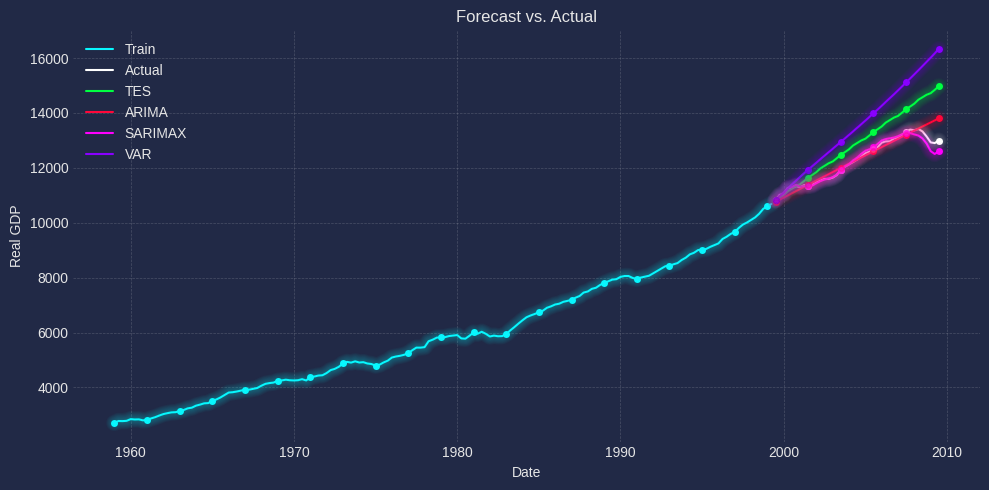

In [33]:
# Plot the tuned forecasts
plot_forecasts(y_train, y_test, forecasts, colors)

In [34]:
# Function to compare metric performances
def evaluate_forecasts(y_test, forecasts, sp=1, y_train=None):
    """
    Evaluates forecast performance for multiple models and returns a styled DataFrame of metrics.

    Parameters:
    - y_test (pd.Series): The actual test data series.
    - forecasts (dict): A dictionary of forecasted data where the keys are model names and values are forecasted pd.Series.
    - sp (int, optional): Seasonal periodicity for calculating MASE. Default is 1.
    - y_train (pd.Series, optional): The actual training data series for calculating MASE.

    Returns:
    - pd.io.formats.style.Styler: A styled DataFrame of evaluation metrics.
    """

    def _calculate_metrics(y_true, y_pred, sp=sp, y_train=y_train):
        """
        Calculate evaluation metrics between true values and predictions.

        Parameters:
        - y_true (pd.Series): The actual values.
        - y_pred (pd.Series): The predicted values.
        - sp (int): Seasonal periodicity for calculating MASE.
        - y_train (pd.Series): The actual training data series for calculating MASE.

        Returns:
        - tuple: A tuple containing MSE, RMSE, MAE, MASE, MAPE, and sMAPE.
        """

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mase = mean_absolute_scaled_error(y_true, y_pred, sp=sp, y_train=y_train)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        smape = mean_absolute_percentage_error(y_true, y_pred, symmetric=True)
        return mse, rmse, mae, mase, mape, smape

    # Check if y_train is provided for MASE calculation
    if y_train is None:
        raise ValueError("y_train must be provided for MASE calculation.")

    # Define metric names and initialize results dictionary
    metrics = ['MSE', 'RMSE', 'MAE', 'MASE', 'MAPE', 'sMAPE']
    results = {}

    # Calculate metrics for each forecast
    for model_name, forecast in forecasts.items():
        results[model_name] = _calculate_metrics(y_test, forecast, sp=sp, y_train=y_train)

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results, index=metrics).T
    results_df.index.name = 'Model'

    # Style the DataFrame
    styled_results_df = results_df.style.set_table_styles(
        [{'selector': 'th.col0', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
         {'selector': 'th', 'props': [('text-align', 'center')]}]
    ).set_properties(**{'text-align': 'center'}).format(precision=3)

    # Highlight the lowest value in each column
    styled_results_df = styled_results_df.highlight_min(color='lightgreen', axis=0)

    return styled_results_df

In [35]:
# Display comparison DataFrame
results_df = evaluate_forecasts(y_test, forecasts, sp=4, y_train=y_train)
display(results_df)

,MSE,RMSE,MAE,MASE,MAPE,sMAPE
Model,,,,,,
TES,651977.201,807.451,649.414,3.075,0.051,0.049
ARIMA,61717.295,248.430,152.533,0.722,0.012,0.012
SARIMAX,17730.967,133.158,84.779,0.401,0.007,0.007
VAR,2311695.788,1520.426,1260.499,5.968,0.099,0.093


# Cross Validation

In [36]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

In [37]:
from sklearn.model_selection import TimeSeriesSplit

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [38]:
# Function to perform cross validation
def cross_validate_forecast(model_class, y_train, tscv, model_params=None, forecast_steps=1, X_train=None, var_lags=None):
    """
    Perform Time Series Cross-Validation for a given model and calculate MAPE scores.

    Parameters:
    - model_class: The model class to be instantiated (e.g., ExponentialSmoothing, ARIMA, SARIMAX, VAR).
    - y_train: pd.Series or pd.DataFrame, the training data.
    - tscv: TimeSeriesSplit object, used for cross-validation.
    - model_params: dict, optional. Parameters to pass when instantiating the model.
    - forecast_steps: int, default=1. The number of steps to forecast ahead.
    - X_train: pd.DataFrame, optional. Exogenous variables for SARIMAX or VAR models.
    - var_lags: int, optional. The number of lags to use in the VAR model.

    Returns:
    - mape_scores: List of MAPE scores for each CV split.
    - mean_mape: The mean MAPE score across all splits.
    """

    mape_scores = []

    if model_params is None:
        model_params = {}

    for train_index, test_index in tscv.split(y_train):
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        if X_train is not None:
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]

        # Handle different model types
        if model_class == SARIMAX:
            model = model_class(y_train_cv, exog=X_train_cv, **model_params).fit(disp=False)
            forecast_cv = model.forecast(steps=len(y_test_cv), exog=X_test_cv)
        elif model_class == VAR:
            model_data = pd.concat([y_train_cv, X_train_cv], axis=1)
            model = model_class(model_data).fit(var_lags)
            forecast_input_cv = model_data.values[-var_lags:]
            forecast_cv = model.forecast(y=forecast_input_cv, steps=len(y_test_cv))
            forecast_cv = pd.DataFrame(forecast_cv, index=y_test_cv.index, columns=[y_train.name] + list(X_train.columns))
            forecast_cv = forecast_cv[y_train.name]
        else:
            model = model_class(y_train_cv, **model_params).fit()
            forecast_cv = model.forecast(steps=len(y_test_cv))

        mape_score = mean_absolute_percentage_error(y_test_cv, forecast_cv)
        mape_scores.append(mape_score)

    mean_mape = np.mean(mape_scores)

    return mape_scores, mean_mape

In [39]:
# Function to create CV boxplot
def plot_cv_boxplot(scores, title='Box Plot', xlabel='Score', color='#8900FF', figsize=(6, 4)):
    """
    Plots a customized box plot with a given list of scores.

    Parameters:
    - scores (list or array-like): The data to be plotted in the box plot.
    - title (str, optional): The title of the plot. Default is 'Box Plot'.
    - xlabel (str, optional): The label for the x-axis. Default is 'Score'.
    - color (str, optional): The color for the box outline and median line. Default is '#8900FF' (neon purple).
    - figsize (tuple, optional): The size of the figure. Default is (6, 4).
    """

    # Create the plot
    plt.figure(figsize=figsize)
    box = plt.boxplot(scores, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='cyan', color=color),
                      whiskerprops=dict(color='white'),
                      capprops=dict(color='white'),
                      medianprops=dict(color=color))

    # Customize the plot appearance
    plt.title(title, color='white')
    plt.xlabel(xlabel, color='white')
    plt.yticks([])

    # Retrieve the median value and print it above the box plot
    median_value = box['medians'][0].get_xdata()[0]
    plt.text(median_value, 1.15, f'{median_value:.3f}', color='white', ha='center')
    plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.25)
    mcp.make_lines_glow()
    plt.show()

## TES

TES CV MAPE: 0.037



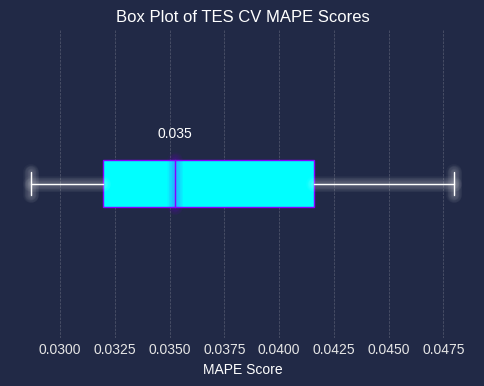

In [40]:
# Set model parameters
tes_params = {
    'trend': best_trend,
    'seasonal': best_seasonal,
    'seasonal_periods': best_seasonal_periods
}

# Perform cross validation
tes_mape_scores, tes_mean_mape = cross_validate_forecast(
    ExponentialSmoothing,
    y_train,
    tscv,
    model_params=tes_params
)
print(f"TES CV MAPE: {tes_mean_mape:.3f}\n")

# Plot the boxplot
plot_cv_boxplot(tes_mape_scores, title='Box Plot of TES CV MAPE Scores', xlabel='MAPE Score')

## ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA CV MAPE: 0.029



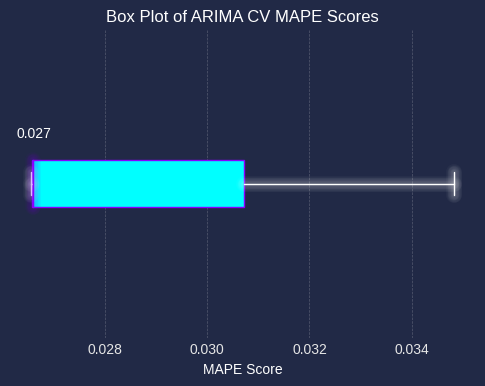

In [41]:
# Set model parameters
arima_params = {'order': best_arima_order}

# Perform cross validation
arima_mape_scores, arima_mean_mape = cross_validate_forecast(
    model_class=ARIMA,
    y_train=y_train,
    tscv=tscv,
    model_params=arima_params
)
print(f"\nARIMA CV MAPE: {arima_mean_mape:.3f}\n")

# Plot the boxplot
plot_cv_boxplot(arima_mape_scores, title='Box Plot of ARIMA CV MAPE Scores', xlabel='MAPE Score')

## SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX CV MAPE: 0.016



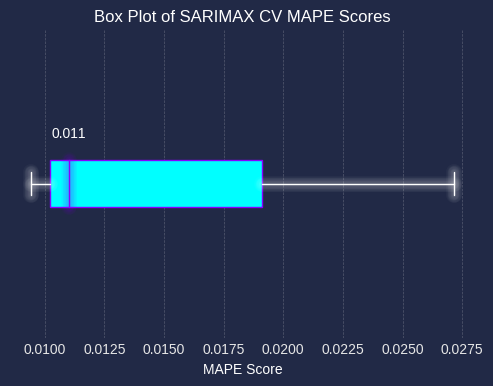

In [42]:
# Set model parameters
sarimax_params = {
    'order': best_sarimax_order,
    'seasonal_order': best_seasonal_order
}

# Perform cross validation
sarimax_mape_scores, sarimax_mean_mape = cross_validate_forecast(
    model_class=SARIMAX,
    y_train=y_train,
    tscv=tscv,
    model_params=sarimax_params,
    X_train=X_train
)
print(f"\nSARIMAX CV MAPE: {sarimax_mean_mape:.3f}\n")

# Plot the boxplot
plot_cv_boxplot(sarimax_mape_scores, title='Box Plot of SARIMAX CV MAPE Scores', xlabel='MAPE Score')

## VAR

VAR CV MAPE: 0.043



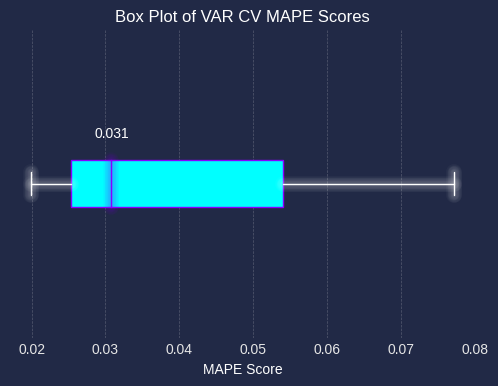

In [43]:
# Set model parameters
var_lags = best_lag

# Perform cross validation
var_mape_scores, var_mean_mape = cross_validate_forecast(
    model_class=VAR,
    y_train=y_train,
    tscv=tscv,
    X_train=X_train,
    var_lags=var_lags
)
print(f"VAR CV MAPE: {var_mean_mape:.3f}\n")

# Plot the boxplot
plot_cv_boxplot(var_mape_scores, title='Box Plot of VAR CV MAPE Scores', xlabel='MAPE Score')

## Results

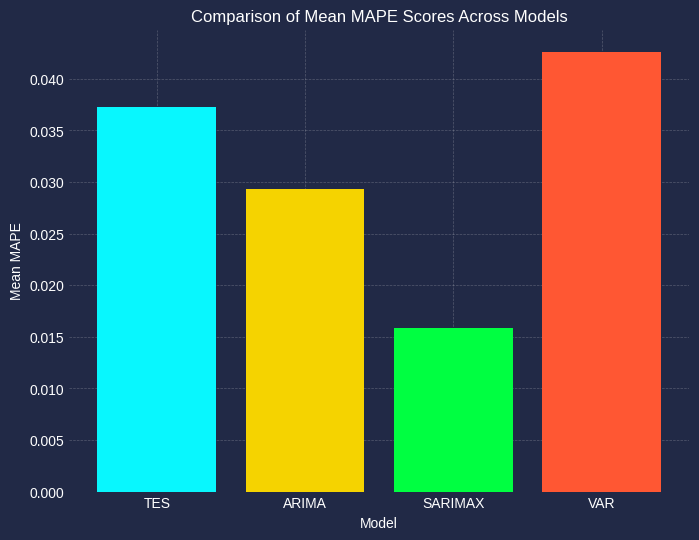

In [44]:
# Store the mean scores in a dictionary
mean_mape_scores = {
    'TES': tes_mean_mape,
    'ARIMA': arima_mean_mape,
    'SARIMAX': sarimax_mean_mape,
    'VAR': var_mean_mape
}

# Convert the dictionary to a DataFrame
mean_mape_df = pd.DataFrame(list(mean_mape_scores.items()), columns=['Model', 'Mean MAPE'])

# Plot bar plot of the mean MAPE scores
plt.figure(figsize=(8, 6))
plt.bar(mean_mape_df['Model'], mean_mape_df['Mean MAPE'], color=['#08F7FE', '#F5D300', '#00ff41', '#FF5733'])
plt.title('Comparison of Mean MAPE Scores Across Models', color='white')
plt.xlabel('Model', color='white')
plt.ylabel('Mean MAPE', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.25)
plt.show()

# Direct Forecasting

In [45]:
# Function to perform direct forecasting
def perform_direct_forecasting(y_train, y_test, order, model_type='ARIMA', seasonal_order=None, X_train=None, X_test=None):
    """
    Perform direct forecasting using ARIMA or SARIMAX with a moving data window.

    Parameters:
    y_train (pd.Series): The training data for the target variable.
    y_test (pd.Series): The test data for the target variable (actual values to compare).
    order (tuple): The order for the ARIMA or SARIMAX model.
    model_type (str): Type of model to use, either 'ARIMA' or 'SARIMAX'.
    seasonal_order (tuple, optional): The seasonal order for the SARIMAX model. If None, no seasonality is considered.
    X_train (pd.DataFrame, optional): Exogenous variables for training. If None, no exogenous variables are used.
    X_test (pd.DataFrame, optional): Exogenous variables for testing. Should match y_test index.

    Returns:
    pd.Series: Forecasted values for the test period.
    float: The Mean Absolute Percentage Error (MAPE) of the forecast.
    """

    # Validate model type
    if model_type not in ['ARIMA', 'SARIMAX']:
        raise ValueError("model_type must be 'ARIMA' or 'SARIMAX'.")

    # Ensure y_train and y_test have no NaN values
    if y_train.isna().any():
        raise ValueError("y_train contains NaN values. Please handle missing data before proceeding.")
    if y_test.isna().any():
        raise ValueError("y_test contains NaN values. Please handle missing data before proceeding.")

    # Ensure X_train and X_test have no NaN values if provided
    if X_train is not None and X_train.isna().any().any():
        raise ValueError("X_train contains NaN values. Please handle missing data before proceeding.")
    if X_test is not None and X_test.isna().any().any():
        raise ValueError("X_test contains NaN values. Please handle missing data before proceeding.")

    # Initialize a list to store forecasts
    forecasts_direct = []

    # Perform direct forecasting for each step in the test set
    print(f"Performing direct forecasting for {len(y_test)} steps using {model_type}...")
    for step in range(len(y_test)):
        # Train a separate model for each step
        if model_type == 'SARIMAX':
            model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
        else:
            model = ARIMA(y_train, exog=X_train, order=order).fit()

        # Forecast the specific step ahead
        if X_test is not None:
            forecast = model.forecast(steps=1, exog=X_test.iloc[[step]]).iloc[-1]
        else:
            forecast = model.forecast(steps=1).iloc[-1]

        # Store the forecasted value
        forecasts_direct.append(forecast)

    # Convert the list of forecasts to a Pandas Series
    forecasts_direct_series = pd.Series(forecasts_direct, index=y_test.index)

    # Calculate the MAPE for the direct forecasts
    mape_direct = mean_absolute_percentage_error(y_test, forecasts_direct_series)
    print(f"\nDirect Forecasting MAPE: {mape_direct:.3f}\n")

    # Convert the index to DatetimeIndex if it is a PeriodIndex
    if isinstance(y_train.index, pd.PeriodIndex):
        y_train.index = y_train.index.to_timestamp()
    if isinstance(y_test.index, pd.PeriodIndex):
        y_test.index = y_test.index.to_timestamp()
    if isinstance(forecasts_direct_series.index, pd.PeriodIndex):
        forecasts_direct_series.index = forecasts_direct_series.index.to_timestamp()

    # Plot the actual values and the direct forecast results
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='Training Data')
    plt.plot(y_test.index, y_test, label='Actual Data', color='white')
    plt.plot(forecasts_direct_series.index, forecasts_direct_series, label=f'{model_type} Direct Forecast', color='#FF073A')
    plt.xlabel('Date')
    plt.ylabel('Real GDP')
    plt.legend(loc='upper left')
    plt.title(f'Direct Forecasting with {model_type}')
    plt.grid(True)
    plt.tight_layout()
    mcp.make_lines_glow()
    plt.show()

    return forecasts_direct_series, mape_direct

## ARIMA

In [46]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

Performing direct forecasting for 41 steps using ARIMA...

Direct Forecasting MAPE: 0.011



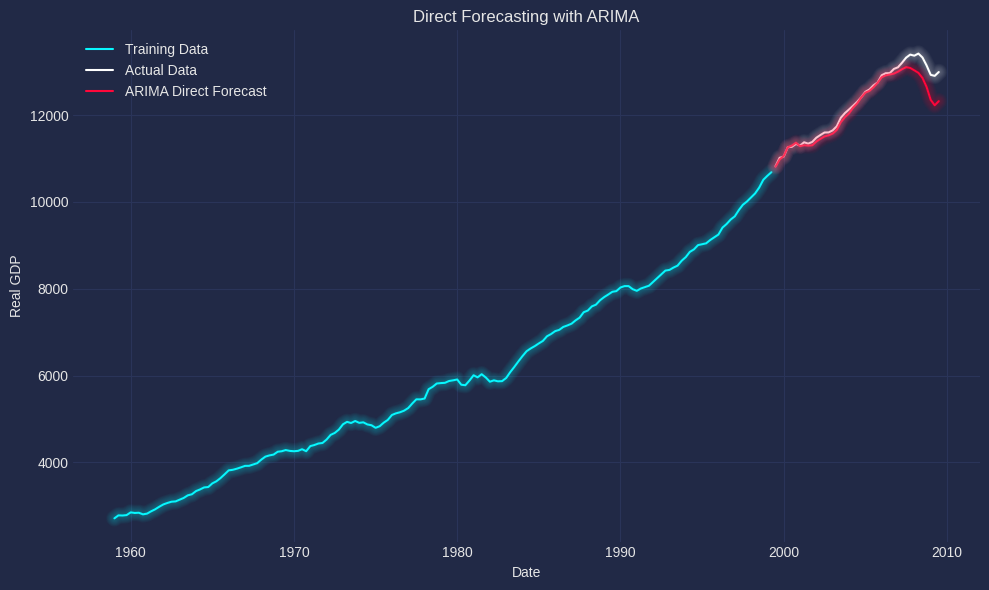

In [47]:
# ARIMA
forecasts_arima, mape_arima = perform_direct_forecasting(
    y_train, y_test,
    order=best_arima_order,
    model_type='ARIMA',
    X_train=X_train, X_test=X_test
)

## SARIMAX

In [48]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

Performing direct forecasting for 41 steps using SARIMAX...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


Direct Forecasting MAPE: 0.016



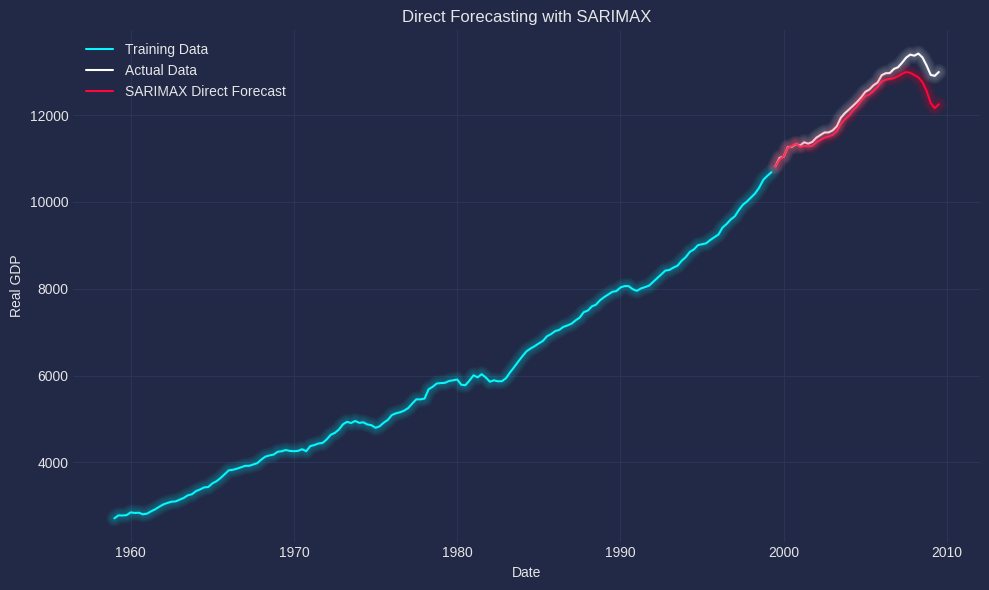

In [49]:
# SARIMAX
forecasts_sarimax, mape_sarimax = perform_direct_forecasting(
    y_train, y_test,
    model_type='SARIMAX',
    order=best_sarimax_order,
    seasonal_order=best_seasonal_order,
    X_train=X_train, X_test=X_test
)

# Filtering

In [50]:
!pip install -q pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [51]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.ndimage import gaussian_filter1d
from pykalman import KalmanFilter

In [52]:
# Convert index to PeriodIndex
converted_list = convert_index([y_train, X_train, y_test, X_test], to_index_type='period')

# Extract list components
y_train, X_train, y_test, X_test = converted_list

# Print info
print('y_train info:')
y_train.info()
print('\nX_train info:')
X_train.info()
print('\ny_test info:')
y_test.info()
print('\nX_test info:')
X_test.info()

y_train info:
<class 'pandas.core.series.Series'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB

X_train info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 162 entries, 1959Q1 to 1999Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realcons  162 non-null    float64
 1   realinv   162 non-null    float64
dtypes: float64(2)
memory usage: 3.8 KB

y_test info:
<class 'pandas.core.series.Series'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes

X_test info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 41 entries, 1999Q3 to 2009Q3
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  --

In [53]:
# Class to perform time series forecasting for ARIMA and SARIMAX with transformations and filtering
class TimeSeriesForecaster:
    def __init__(self, y_train, y_test, X_train=None, X_test=None):
        """
        Initialize the TimeSeriesForecaster.

        Parameters:
        y_train (pd.Series): The training data for the target variable.
        y_test (pd.Series): The test data for the target variable.
        X_train (pd.DataFrame, optional): Exogenous variables for training. Default is None.
        X_test (pd.DataFrame, optional): Exogenous variables for testing. Default is None.
        """
        self.y_train = y_train
        self.y_test = y_test
        self.X_train = X_train
        self.X_test = X_test
        self.results = {}

    def _apply_filtering(self, y_train, filter_type):
        """Apply the specified filtering to the training data."""
        if filter_type == 'gaussian':
            y_train_filtered = gaussian_filter1d(y_train, sigma=2)
        elif filter_type == 'kalman':
            kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
            y_train_filtered, _ = kf.filter(y_train)
        else:
            y_train_filtered = y_train

        return y_train_filtered

    def _apply_transformation(self, y_train_filtered, transformation):
        """Apply the specified transformation to the filtered training data."""
        fitted_lambda = None

        y_train_filtered = y_train_filtered.flatten()
        y_train_filtered = y_train_filtered[~np.isnan(y_train_filtered)]

        if transformation == 'log':
            y_train_transformed = np.log(y_train_filtered)
        elif transformation == 'boxcox':
            y_train_transformed, fitted_lambda = boxcox(y_train_filtered)
        else:
            y_train_transformed = y_train_filtered.copy()

        return y_train_transformed, fitted_lambda

    def _reverse_transformation(self, forecast, transformation, fitted_lambda):
        """Reverse the transformation applied to the data."""
        if transformation == 'log':
            forecast_reversed = np.exp(forecast)
        elif transformation == 'boxcox':
            forecast_reversed = inv_boxcox(forecast, fitted_lambda)
        else:
            forecast_reversed = forecast
        return forecast_reversed

    def _grid_search(self, model_type, y_train_transformed, param_grid, seasonal_order=None, transformation=None, fitted_lambda=None):
        """Perform grid search to find the best model."""
        best_mape = float('inf')
        best_model = None
        best_order = None
        best_seasonal_order = None

        for order in param_grid:
            try:
                print(f"\nTesting {model_type} order={order}")

                if model_type == 'ARIMA':
                    model = ARIMA(y_train_transformed, exog=self.X_train if self.X_train is not None else None, order=order).fit()
                    forecast = model.forecast(len(self.y_test), exog=self.X_test if self.X_test is not None else None)
                elif model_type == 'SARIMAX':
                    model = SARIMAX(y_train_transformed, exog=self.X_train if self.X_train is not None else None, order=order[:3], seasonal_order=seasonal_order).fit(disp=False)
                    forecast = model.forecast(len(self.y_test), exog=self.X_test if self.X_test is not None else None)
                else:
                    raise ValueError("Invalid model_type. Choose either 'ARIMA' or 'SARIMAX'.")

                # Reverse transformation before evaluation
                forecast_reversed = self._reverse_transformation(forecast, transformation, fitted_lambda)
                mape = mean_absolute_percentage_error(self.y_test, forecast_reversed)
                print(f"Test MAPE={mape:.3f}")

                if mape < best_mape:
                    best_mape = mape
                    best_model = model
                    best_order = order[:3]
                    best_seasonal_order = seasonal_order if model_type == 'SARIMAX' else None
                    print(f"New best model: {model_type} order={order} with MAPE={mape:.3f}")

            except Exception as e:
                print(f"Error with {model_type} order={order}: {e}")
                continue

        return best_model, best_order, best_seasonal_order, best_mape

    def forecast(self, model_types, param_grids, transformation=None, filter_type=None, seasonal_arima=False, seasonal_order=None):
        """
        Perform forecasting for specified models with transformations and filtering.

        Parameters:
        model_types (list): List of model types to use ('ARIMA' and/or 'SARIMAX').
        param_grids (dict): Dictionary of parameter grids for each model type.
        transformation (str, optional): Type of transformation to apply ('log' or 'boxcox').
        filter_type (str, optional): Type of filter to apply ('gaussian' or 'kalman').
        seasonal_arima (bool, optional): Whether to search for seasonal_order in ARIMA. Default is False.
        seasonal_order (tuple, optional): Seasonal order for SARIMAX or ARIMA. Default is None.
        """

        # Apply filtering first, then apply transformation
        y_train_filtered = self._apply_filtering(self.y_train, filter_type)
        y_train_transformed, fitted_lambda = self._apply_transformation(y_train_filtered, transformation)

        for model_type in model_types:
            print(f"\nStarting grid search for {model_type}...")
            best_model, best_order, best_seasonal_order, best_mape = self._grid_search(
                model_type, y_train_transformed, param_grids[model_type],
                seasonal_order=seasonal_order if model_type == 'SARIMAX' else None,
                transformation=transformation, fitted_lambda=fitted_lambda
            )

            if best_model:
                print(f"\nBest {model_type} model: order={best_order}, seasonal_order={best_seasonal_order}, MAPE={best_mape}")
                forecast = best_model.forecast(len(self.y_test), exog=self.X_test if model_type == 'SARIMAX' or (model_type == 'ARIMA' and self.X_test is not None) else None)

                # Reverse the transformation before storing results
                forecast_reversed = self._reverse_transformation(forecast, transformation, fitted_lambda)

                self.results[model_type] = {
                    'forecast': pd.Series(forecast_reversed, index=self.y_test.index),
                    'mape': best_mape
                }
            else:
                print(f"No valid {model_type} model was found.")

    def plot_forecasts(self, colors, marker_interval=8, title='Forecast vs. Actual'):
        """Plot the forecasts from all models along with the training and actual data."""
        # Store the original indices
        original_train_index = self.y_train.index
        original_test_index = self.y_test.index

        # Convert PeriodIndex to DatetimeIndex for plotting if necessary
        if isinstance(self.y_train.index, pd.PeriodIndex):
            self.y_train.index = self.y_train.index.to_timestamp()
            self.y_test.index = self.y_test.index.to_timestamp()
            for model_type, result in self.results.items():
                result['forecast'].index = result['forecast'].index.to_timestamp()

        # Print debug information
        print("\nPlotting data:")
        print("Training data index:", self.y_train.index)
        print("Test data index:", self.y_test.index)
        for model_type, result in self.results.items():
            print(f"{model_type} forecast index:", result['forecast'].index)

        # Plotting
        plt.figure(figsize=(10, 5))

        # Plot the training data
        plt.plot(self.y_train.index, self.y_train, label='Train', color=colors['Train'], linestyle='-')
        plt.plot(self.y_train.index[::marker_interval], self.y_train[::marker_interval], label='_nolegend_', color=colors['Train'], linestyle='None', marker='o', markersize=4)

        # Plot the actual data
        plt.plot(self.y_test.index, self.y_test, label='Actual', color=colors['Actual'], linestyle='-')
        plt.plot(self.y_test.index[::marker_interval], self.y_test[::marker_interval], label='_nolegend_', color=colors['Actual'], linestyle='None', marker='o', markersize=4)

        # Plot forecasts
        for model_type, result in self.results.items():
            forecast = result['forecast']
            plt.plot(forecast.index, forecast, label=f"{model_type} (MAPE={result['mape']:.3f})", color=colors[model_type], linestyle='-')
            plt.plot(forecast.index[::marker_interval], forecast[::marker_interval], label='_nolegend_', color=colors[model_type], linestyle='None', marker='o', markersize=4)

        plt.xlabel('Date')
        plt.ylabel('Real GDP')
        plt.legend(loc='upper left')
        plt.title(title)
        plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
        mcp.make_lines_glow()
        plt.tight_layout()
        plt.show()

        # Convert back to original PeriodIndex if necessary
        if isinstance(original_train_index, pd.PeriodIndex):
            self.y_train.index = original_train_index
            self.y_test.index = original_test_index
            for model_type, result in self.results.items():
                result['forecast'].index = original_test_index

In [54]:
# Define parameter grids for ARIMA and SARIMAX
param_grids = {
    'ARIMA': [
        (p, d, q)
        for p in range(3)   # AR terms
        for d in range(2)   # Differencing terms
        for q in range(3)   # MA terms
    ],
    'SARIMAX': [
        (p, d, q, P, D, Q, s)
        for p in range(3)      # AR terms
        for d in range(2)      # Differencing terms
        for q in range(3)      # MA terms
        for P in range(2)      # Seasonal AR terms
        for D in range(2)      # Seasonal differencing terms
        for Q in range(2)      # Seasonal MA terms
        for s in [4]           # Seasonal periods (quarterly data)
    ]
}

# Define colors for plotting
colors = {
    'Train': '#08F7FE',
    'Actual': 'white',
    'ARIMA': '#2ca02c',
    'SARIMAX': '#d62728'
}

In [55]:
# Initialize the TimeSeriesForecaster
forecaster = TimeSeriesForecaster(y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test)

# Perform forecasting for ARIMA and SARIMAX
forecaster.forecast(
    model_types=['ARIMA', 'SARIMAX'],
    param_grids=param_grids,
    transformation='boxcox',
    filter_type='kalman',
    seasonal_arima=False,
    seasonal_order=(1, 1, 1, 4)
)


Starting grid search for ARIMA...

Testing ARIMA order=(0, 0, 0)
Test MAPE=0.173
New best model: ARIMA order=(0, 0, 0) with MAPE=0.173

Testing ARIMA order=(0, 0, 1)
Test MAPE=0.186

Testing ARIMA order=(0, 0, 2)
Test MAPE=0.205

Testing ARIMA order=(0, 1, 0)
Test MAPE=0.055
New best model: ARIMA order=(0, 1, 0) with MAPE=0.055

Testing ARIMA order=(0, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.055
New best model: ARIMA order=(0, 1, 1) with MAPE=0.055

Testing ARIMA order=(0, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.039
New best model: ARIMA order=(0, 1, 2) with MAPE=0.039

Testing ARIMA order=(1, 0, 0)
Test MAPE=0.185

Testing ARIMA order=(1, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.091

Testing ARIMA order=(1, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.079

Testing ARIMA order=(1, 1, 0)
Test MAPE=0.012
New best model: ARIMA order=(1, 1, 0) with MAPE=0.012

Testing ARIMA order=(1, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Test MAPE=0.070

Testing ARIMA order=(1, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.012
New best model: ARIMA order=(1, 1, 2) with MAPE=0.012

Testing ARIMA order=(2, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.217

Testing ARIMA order=(2, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.121

Testing ARIMA order=(2, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.209

Testing ARIMA order=(2, 1, 0)
Test MAPE=0.007
New best model: ARIMA order=(2, 1, 0) with MAPE=0.007

Testing ARIMA order=(2, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing ARIMA order=(2, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.061

Best ARIMA model: order=(2, 1, 0), seasonal_order=None, MAPE=0.00714058255054557

Starting grid search for SARIMAX...

Testing SARIMAX order=(0, 0, 0, 0, 0, 0, 4)
Test MAPE=0.021
New best model: SARIMAX order=(0, 0, 0, 0, 0, 0, 4) with MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 0, 0, 1, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 0, 1, 0, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 0, 1, 1, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 1, 0, 0, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 1, 0, 1, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 1, 1, 0, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 0, 1, 1, 1, 4)
Test MAPE=0.021

Testing SARIMAX order=(0, 0, 1, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 1, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.026

Testing SARIMAX order=(0, 0, 2, 0, 0, 0, 4)
Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 0, 2, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.032

Testing SARIMAX order=(0, 1, 0, 0, 0, 0, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 0, 0, 1, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 0, 1, 0, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 0, 1, 1, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 1, 0, 0, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 1, 0, 1, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 1, 1, 0, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 0, 1, 1, 1, 4)
Test MAPE=0.050

Testing SARIMAX order=(0, 1, 1, 0, 0, 0, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 0, 0, 1, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 0, 1, 0, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 0, 1, 1, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 1, 0, 0, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 1, 0, 1, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 1, 1, 0, 4)
Test MAPE=0.022

Testing SARIMAX order=(0, 1, 1, 1, 1, 1, 4)
Test MAPE=0.022

Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(0, 1, 2, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.026

Testing SARIMAX order=(1, 0, 0, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 0, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.033

Testing SARIMAX order=(1, 0, 1, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007
New best model: SARIMAX order=(1, 0, 1, 0, 0, 0, 4) with MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 1, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.007

Testing SARIMAX order=(1, 0, 2, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 0, 2, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.042

Testing SARIMAX order=(1, 1, 0, 0, 0, 0, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 0, 0, 1, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 0, 1, 0, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 0, 1, 1, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 1, 0, 0, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 1, 0, 1, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 1, 1, 0, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 0, 1, 1, 1, 4)
Test MAPE=0.068

Testing SARIMAX order=(1, 1, 1, 0, 0, 0, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 0, 0, 1, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 0, 1, 0, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 0, 1, 1, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 1, 0, 0, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 1, 0, 1, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 1, 1, 0, 4)
Test MAPE=0.038

Testing SARIMAX order=(1, 1, 1, 1, 1, 1, 4)
Test MAPE=0.038

Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.083

Testing SARIMAX order=(1, 1, 2, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.083

Testing SARIMAX order=(2, 0, 0, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 0, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.049

Testing SARIMAX order=(2, 0, 1, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 1, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.030

Testing SARIMAX order=(2, 0, 2, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 0, 2, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.048

Testing SARIMAX order=(2, 1, 0, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 0, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.291

Testing SARIMAX order=(2, 1, 1, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 1, 1, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.060

Testing SARIMAX order=(2, 1, 2, 0, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 0, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 0, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 0, 1, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 1, 0, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 1, 0, 1, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 1, 1, 0, 4)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MAPE=0.134

Testing SARIMAX order=(2, 1, 2, 1, 1, 1, 4)
Test MAPE=0.134

Best SARIMAX model: order=(1, 0, 1), seasonal_order=(1, 1, 1, 4), MAPE=0.006859770128280509


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Plotting data:
Training data index: DatetimeIndex(['1959-01-01', '1959-04-01', '1959-07-01', '1959-10-01',
               '1960-01-01', '1960-04-01', '1960-07-01', '1960-10-01',
               '1961-01-01', '1961-04-01',
               ...
               '1997-01-01', '1997-04-01', '1997-07-01', '1997-10-01',
               '1998-01-01', '1998-04-01', '1998-07-01', '1998-10-01',
               '1999-01-01', '1999-04-01'],
              dtype='datetime64[ns]', name='date', length=162, freq='QS-OCT')
Test data index: DatetimeIndex(['1999-07-01', '1999-10-01', '2000-01-01', '2000-04-01',
               '2000-07-01', '2000-10-01', '2001-01-01', '2001-04-01',
               '2001-07-01', '2001-10-01', '2002-01-01', '2002-04-01',
               '2002-07-01', '2002-10-01', '2003-01-01', '2003-04-01',
               '2003-07-01', '2003-10-01', '2004-01-01', '2004-04-01',
               '2004-07-01', '2004-10-01', '2005-01-01', '2005-04-01',
               '2005-07-01', '2005-10-01', '2006-01-

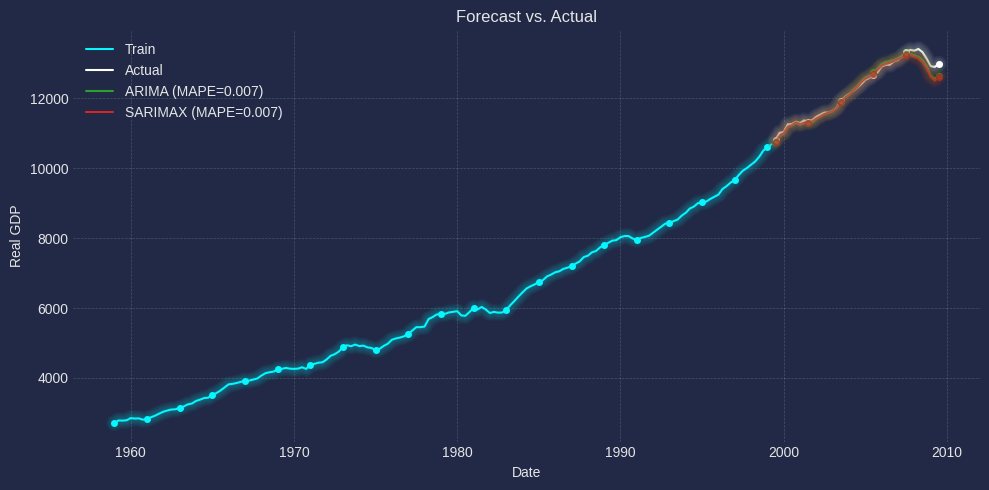

In [56]:
# Plot the forecasts
forecaster.plot_forecasts(colors=colors, title='Forecast vs. Actual')

# More Forecasting

In [57]:
!pip install -q sktime mplcyberpunk

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import macrodata
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_percentage_error
import statsmodels.api as sm
import mplcyberpunk as mcp
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb

plt.style.use('cyberpunk')

In [59]:
# Function to load the data
def load_macrodata_time_series(column='realgdp'):
    """
    Loads the US macroeconomic dataset, processes the date information,
    and returns the specified time series as a PeriodIndex.

    Parameters:
    - column (str): The name of the column to select as the time series.
                    Default is 'realgdp'.

    Returns:
    - pd.Series: The processed time series with a PeriodIndex.
    """
    # Load the US macroeconomic dataset
    data = macrodata.load_pandas().data

    # Manually create the month corresponding to each quarter
    month = (data['quarter'] - 1) * 3 + 1

    # Combine year and month to create a datetime object
    dates = pd.to_datetime(data['year'].astype(int).astype(str) + '-' + month.astype(int).astype(str) + '-01')

    # Add the dates as a datetime index to the DataFrame
    data.index = dates
    data.index.name = 'date'  # Naming the index

    # Convert to a PeriodIndex to represent quarterly data
    data.index = data.index.to_period('Q')

    # Select the specified column as the time series
    time_series = data[column]

    # Display the first few rows
    display(time_series.head())
    print('\n')

    # Print info
    time_series.info()

    return time_series

In [60]:
# Load and display the data
time_series = load_macrodata_time_series('realgdp')

,realgdp
date,
1959Q1,2710.349
1959Q2,2778.801
1959Q3,2775.488
1959Q4,2785.204
1960Q1,2847.699




<class 'pandas.core.series.Series'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Series name: realgdp
Non-Null Count  Dtype  
--------------  -----  
203 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


## LSTM

In [61]:
# Perform time series forecasting with LSTM model
class LSTMTimeSeriesModel:
    def __init__(self, look_back, split_frac, transform, lstm_params, scale=True, missing_data_strategy='drop', validation_split=0.2, patience=5):
        """
        Initializes the LSTMTimeSeriesModel class.

        Parameters:
        look_back (int): Number of previous time steps to consider as input features.
        split_frac (float): Fraction of data to use for training.
        transform (str): Specifies the transformation to apply ('log', 'diff', 'log_diff', or 'none').
        lstm_params (tuple): Tuple containing the number of LSTM units, epochs, and verbosity level.
        scale (bool): Whether to scale the data or not.
        missing_data_strategy (str): Strategy for handling missing data ('drop', 'mean', 'ffill', 'bfill', 'iterative').
        validation_split (float): Fraction of training data to use for validation.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        """

        self.look_back = look_back
        self.split_frac = split_frac
        self.transform = transform
        self.lstm_units = lstm_params[0]
        self.epochs = lstm_params[1]
        self.verbose = lstm_params[2]
        self.scale = scale
        self.missing_data_strategy = missing_data_strategy
        self.validation_split = validation_split
        self.patience = patience
        self.scaler = MinMaxScaler(feature_range=(0, 1)) if self.scale else None
        self.model = None

    def _apply_transforms(self, data_series):
        """
        Applies the specified transformations to the data series.

        Parameters:
        data_series (pd.Series): Time series data.

        Returns:
        pd.Series: Transformed data series.
        """
        if self.transform == 'log':  # Log transform
            data_series = np.log(data_series)
        elif self.transform == 'diff':  # Differencing
            data_series = data_series.diff().dropna()
        elif self.transform == 'log_diff':  # Log transform + differencing
            data_series = np.log(data_series).diff().dropna()

        if self.scale:
            data_series = pd.Series(self.scaler.fit_transform(data_series.values.reshape(-1, 1)).flatten(),
                                    index=data_series.index)

        return data_series

    def _handle_missing_data(self, df):
        """
        Handles missing data based on the specified strategy.

        Parameters:
        df (pd.DataFrame): DataFrame with potential missing data.

        Returns:
        pd.DataFrame: DataFrame with missing data handled.
        """
        if self.missing_data_strategy == 'drop':
            df = df.dropna()
        elif self.missing_data_strategy == 'mean':
            df = df.fillna(df.mean())
        elif self.missing_data_strategy == 'ffill':
            df = df.fillna(method='ffill')
        elif self.missing_data_strategy == 'bfill':
            df = df.fillna(method='bfill')
        elif self.missing_data_strategy == 'iterative':
            imputer = IterativeImputer(max_iter=10, random_state=0)
            df[:] = imputer.fit_transform(df)

        return df

    def _inverse_transforms(self, series, original_data, dates):
        """
        Reverses the transformations applied to the data.

        Parameters:
        series (pd.Series): Data series to be inverse transformed.
        original_data (pd.Series): Original untransformed data series.
        dates (pd.PeriodIndex): Dates corresponding to the data.

        Returns:
        pd.Series: Inverse transformed data series.
        """
        if self.scale:
            series = pd.Series(self.scaler.inverse_transform(series.values.reshape(-1, 1))[:, 0], index=dates)

        if self.transform == 'diff':  # Reverse differencing
            series = series.add(original_data.shift(1)).dropna()
        elif self.transform == 'log_diff':  # Reverse log transform + differencing
            series = series.add(original_data.shift(1)).dropna()
            series = np.exp(series)
        elif self.transform == 'log':  # Reverse log transform
            series = np.exp(series)

        return series

    def create_dataset(self, data_series):
        """
        Prepares the dataset for LSTM model training.

        Parameters:
        data_series (pd.Series): Time series data.

        Returns:
        tuple: Training and testing data (X_train, y_train, X_test, y_test), dates, and scaler.
        """
        data_series = self._apply_transforms(data_series)
        dates = data_series.index

        df = pd.DataFrame()
        for i in range(self.look_back + 1):
            df[f't-{i}'] = data_series.shift(i)

        df = self._handle_missing_data(df)

        split_index = int(self.split_frac * len(df))
        train, test = df.iloc[:split_index], df.iloc[split_index:]

        X_train, y_train = train.iloc[:, 1:].values, train.iloc[:, 0].values
        X_test, y_test = test.iloc[:, 1:].values, test.iloc[:, 0].values

        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        return X_train, y_train, X_test, y_test, train.index, test.index

    def build_model(self):
        """
        Builds and compiles the LSTM model.
        """
        model = Sequential()
        model.add(Input(shape=(1, self.look_back)))
        model.add(LSTM(self.lstm_units))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.model = model

        # Print the model summary
        self.model.summary()
        print("\n")

    def train_model(self, X_train, y_train, X_val=None, y_val=None, checkpoint_path='best_model.keras'):
        """
        Trains the LSTM model with early stopping and model checkpointing.

        Parameters:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training target values.
        X_val (np.ndarray): Validation features.
        y_val (np.ndarray): Validation target values.
        checkpoint_path (str): Path where the model checkpoint will be saved.
        """
        callbacks = []

        # Early stopping to prevent overfitting
        if X_val is not None and y_val is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
            callbacks.append(early_stopping)

        # Model checkpoint to save the best model
        checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
        callbacks.append(checkpoint)

        # Train the model with callbacks
        if X_val is not None and y_val is not None:
            self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=1, verbose=self.verbose,
                           validation_data=(X_val, y_val), callbacks=callbacks)
        else:
            self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=1, verbose=self.verbose,
                           callbacks=callbacks)

    def predict(self, X):
        """
        Makes predictions using the trained model.

        Parameters:
        X (np.ndarray): Input data for predictions.

        Returns:
        np.ndarray: Predicted values.
        """
        return self.model.predict(X)

    def evaluate(self, y_true, y_pred):
        """
        Evaluates the model using RMSE and MAPE.

        Parameters:
        y_true (pd.Series): Actual values.
        y_pred (pd.Series): Predicted values.

        Returns:
        tuple: RMSE and MAPE values.
        """
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    def plot_predictions(self, y_train, train_predict, y_val, val_predict, y_test, test_predict, original_data):
        """
        Plots the original data, actual vs. predicted values for training, validation, and test sets.

        Parameters:
        y_train (pd.Series): Actual training values.
        train_predict (pd.Series): Predicted training values.
        y_val (pd.Series): Actual validation values.
        val_predict (pd.Series): Predicted validation values.
        y_test (pd.Series): Actual test values.
        test_predict (pd.Series): Predicted test values.
        original_data (pd.Series): Original untransformed time series data.
        """
        # Convert PeriodIndex to DatetimeIndex for plotting
        y_train = y_train.to_timestamp()
        train_predict = train_predict.to_timestamp()
        y_val = y_val.to_timestamp()
        val_predict = val_predict.to_timestamp()
        y_test = y_test.to_timestamp()
        test_predict = test_predict.to_timestamp()
        original_data = original_data.to_timestamp()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        ax.plot(original_data, label='Original Data', color='blue')
        ax.plot(y_train, label='Train Actual', color='cyan')
        ax.plot(train_predict, label='Train Predicted', color='green')
        ax.plot(y_val, label='Val Actual', color='orange')
        ax.plot(val_predict, label='Val Predicted', color='purple')
        ax.plot(y_test, label='Test Actual', color='magenta')
        ax.plot(test_predict, label='Test Predicted', color='red')

        ax.legend()
        plt.title('Actual vs. Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Real GDP')
        plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
        plt.tight_layout()
        mcp.make_lines_glow()
        plt.show()

    def run(self, data_series, checkpoint_path='best_model.keras'):
        """
        Runs the entire process of data preparation, model training, prediction, and evaluation.

        Parameters:
        data_series (pd.Series): Time series data.
        checkpoint_path (str): Path to the saved best model.

        Returns:
        tuple: Inverse transformed predictions and actual values for train, validation, and test sets.
        """
        X_train, y_train, X_test, y_test, train_dates, test_dates = self.create_dataset(data_series)

        # Splitting training data for validation
        val_size = int(self.validation_split * len(X_train))
        X_val, y_val = X_train[-val_size:], y_train[-val_size:]
        X_train, y_train = X_train[:-val_size], y_train[:-val_size]

        self.build_model()
        self.train_model(X_train, y_train, X_val, y_val)

        self.model = load_model(checkpoint_path)

        train_predict = self.predict(X_train)
        val_predict = self.predict(X_val)
        test_predict = self.predict(X_test)

        train_predict = self._inverse_transforms(pd.Series(train_predict.flatten(), index=train_dates[:-val_size]), data_series, train_dates[:-val_size])
        y_train = self._inverse_transforms(pd.Series(y_train.flatten(), index=train_dates[:-val_size]), data_series, train_dates[:-val_size])

        val_predict = self._inverse_transforms(pd.Series(val_predict.flatten(), index=train_dates[-val_size:]), data_series, train_dates[-val_size:])
        y_val = self._inverse_transforms(pd.Series(y_val.flatten(), index=train_dates[-val_size:]), data_series, train_dates[-val_size:])

        test_predict = self._inverse_transforms(pd.Series(test_predict.flatten(), index=test_dates), data_series, test_dates)
        y_test = self._inverse_transforms(pd.Series(y_test.flatten(), index=test_dates), data_series, test_dates)

        print("\n")
        self.plot_predictions(y_train, train_predict, y_val, val_predict, y_test, test_predict, data_series)

        train_rmse, train_mape = self.evaluate(y_train, train_predict)
        val_rmse, val_mape = self.evaluate(y_val, val_predict)
        test_rmse, test_mape = self.evaluate(y_test, test_predict)

        print(f"\nTrain RMSE: {train_rmse:.3f}")
        print(f"Train MAPE: {train_mape:.3f}")
        print(f"Val RMSE: {val_rmse:.3f}")
        print(f"Val MAPE: {val_mape:.3f}")
        print(f"Test RMSE: {test_rmse:.3f}")
        print(f"Test MAPE: {test_mape:.3f}")

        return test_predict, test_rmse, test_mape

In [62]:
# Parameters for the LSTM model
look_back = 5                   # Number of previous time steps to use as input features
split_frac = 0.8                # 80% of the data for training, 20% for testing
transform = 'diff'              # Apply differencing
lstm_params = (50, 50, 1)       # 50 LSTM units, 50 epochs, verbose output
scale = True                    # Apply scaling
missing_data_strategy = 'mean'  # Fill missing data with the mean
validation_split = 0.2          # 20% of training data for validation
patience = 7                    # Patience for early stopping

In [63]:
# Initialize the modeling script
lstm_model = LSTMTimeSeriesModel(
    look_back=look_back,
    split_frac=split_frac,
    transform=transform,
    lstm_params=lstm_params,
    scale=scale,
    missing_data_strategy=missing_data_strategy,
    validation_split=validation_split,
    patience=patience
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1413 - val_loss: 0.0084
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - val_loss: 0.0084
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - val_loss: 0.0095
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0187 - val_loss: 0.0109
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0140 - val_loss: 0.0128
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0099
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0111
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 




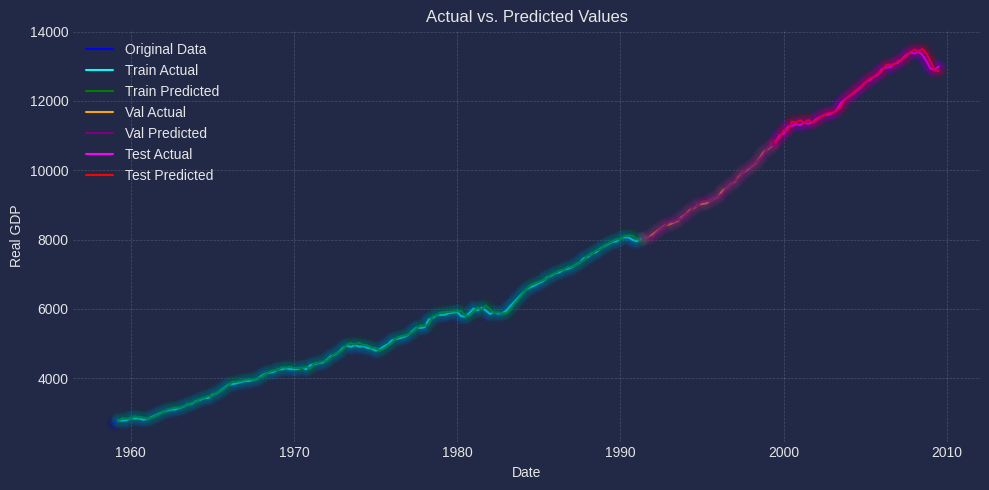


Train RMSE: 53.615
Train MAPE: 0.009
Val RMSE: 39.473
Val MAPE: 0.003
Test RMSE: 83.378
Test MAPE: 0.005


In [64]:
# Run the modeling process
lstm_pred, lstm_rmse, lstm_mape = lstm_model.run(time_series)

## ARIMA

In [65]:
# Perform time series forecasting with ARIMA model
class ARIMATimeSeriesModel:
    def __init__(self, p, d, q, split_frac, transform='none', scale=False, missing_data_strategy='drop'):
        self.p = p
        self.d = d
        self.q = q
        self.split_frac = split_frac
        self.transform = transform
        self.scale = scale
        self.missing_data_strategy = missing_data_strategy
        self.scaler = MinMaxScaler(feature_range=(0, 1)) if self.scale else None
        self.model = None

    def _apply_transforms(self, data_series):
        print("Applying transformations:", self.transform)
        if self.transform == 'log':
            data_series = np.log(data_series)
        elif self.transform == 'diff':
            data_series = data_series.diff().dropna()
        elif self.transform == 'log_diff':
            data_series = np.log(data_series).diff().dropna()

        if self.scale:
            print("Applying scaling...")
            data_series = pd.Series(self.scaler.fit_transform(data_series.values.reshape(-1, 1)).flatten(),
                                    index=data_series.index)

        print(f"Data series length after transformation: {len(data_series)}")
        return data_series

    def _handle_missing_data(self, df):
        print(f"Handling missing data with strategy: {self.missing_data_strategy}")
        if self.missing_data_strategy == 'drop':
            df = df.dropna()
        elif self.missing_data_strategy == 'mean':
            df = df.fillna(df.mean())
        elif self.missing_data_strategy == 'ffill':
            df = df.fillna(method='ffill')
        elif self.missing_data_strategy == 'bfill':
            df = df.fillna(method='bfill')
        elif self.missing_data_strategy == 'iterative':
            imputer = IterativeImputer(max_iter=10, random_state=0)
            df[:] = imputer.fit_transform(df)

        return df

    def _inverse_transforms(self, series, original_data, dates):
        if self.scale:
            series = pd.Series(self.scaler.inverse_transform(series.values.reshape(-1, 1))[:, 0], index=dates)

        if self.transform == 'diff':
            series = series.add(original_data.shift(1)).dropna()
        elif self.transform == 'log_diff':
            series = series.add(original_data.shift(1)).dropna()
            series = np.exp(series)
        elif self.transform == 'log':
            series = np.exp(series)

        return series

    def create_dataset(self, data_series):
        print("Creating dataset...")
        data_series = self._apply_transforms(data_series)

        print(f"\nData series after transformation: {data_series.head()}")
        print(f"Data series data type: {data_series.dtype}")
        print(f"Data series shape: {data_series.shape}")

        dates = data_series.index

        print(f"\nDates index type: {type(dates)}")
        print(f"Dates index: {dates}")

        split_index = int(self.split_frac * len(data_series))
        train, test = data_series.iloc[:split_index], data_series.iloc[split_index:]

        print(f"\nTraining data head:\n{train.head()}")
        print(f"Training data shape: {train.shape}")
        print(f"Training data type: {train.dtype}")

        print(f"\nTest data head:\n{test.head()}")
        print(f"Test data shape: {test.shape}")
        print(f"Test data type: {test.dtype}")

        print(f"\nTraining dates index: {dates[:split_index]}")
        print(f"Test dates index: {dates[split_index:]}")

        return train, test, dates[:split_index], dates[split_index:]

    def build_model(self, history):
        print(f"Building ARIMA model with history length: {len(history)}")
        if len(history) >= max(self.p, self.d, self.q) + 1:
            self.model = ARIMA(history, order=(self.p, self.d, self.q))
            self.model = self.model.fit()
        else:
            raise ValueError("Insufficient data points in history to fit the ARIMA model.")

    def rolling_forecast(self, train, test):
        print("\nStarting rolling forecast...")
        predictions = []
        history = train.copy()

        print(f"Initial history size: {len(history)}")

        for t in range(len(test)):
            try:
                print(f"\nRolling forecast step: {t + 1}")
                if len(history) < max(self.p, self.d, self.q) + 1:
                    raise ValueError(f"Step {t + 1}: Insufficient data points in history to fit the ARIMA model.")

                self.build_model(history)
                output = self.model.forecast()
                yhat = output.iloc[0]
                predictions.append(yhat)
                obs = test.iloc[t]
                history = pd.concat([history, pd.Series(obs, index=[test.index[t]])])
                print(f"Observed: {obs}, Predicted: {yhat}")
                print(f"Updated history size: {len(history)}")
            except Exception as e:
                print(f"An error occurred during the rolling forecast at step {t + 1}: {e}")
                break

        return pd.Series(predictions, index=test.index) if predictions else pd.Series()

    def plot_predictions(self, y_train, y_test, test_predict, original_data):
        # Convert PeriodIndex to DatetimeIndex for plotting
        if isinstance(y_train.index, pd.PeriodIndex):
            y_train = y_train.to_timestamp()
        if isinstance(y_test.index, pd.PeriodIndex):
            y_test = y_test.to_timestamp()
        if isinstance(test_predict.index, pd.PeriodIndex):
            test_predict = test_predict.to_timestamp()
        if isinstance(original_data.index, pd.PeriodIndex):
            original_data = original_data.to_timestamp()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        ax.plot(original_data, label='Original Data', color='blue')
        ax.plot(y_train, label='Train Actual', color='cyan')
        ax.plot(y_test, label='Test Actual', color='magenta')
        ax.plot(test_predict, label='Test Predicted', color='red')

        ax.legend()
        plt.title('Actual vs. Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Real GDP')
        plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
        plt.tight_layout()
        mcp.make_lines_glow()
        plt.show()

    def evaluate(self, y_true, y_pred):
        if y_pred.empty:
            return np.nan, np.nan
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    def run(self, data_series):
        print("Running the ARIMA model process...")
        train_data, test_data, train_dates, test_dates = self.create_dataset(data_series)

        # Rolling forecast
        try:
            test_predict = self.rolling_forecast(train_data, test_data)
        except ValueError as ve:
            print(f"Error during rolling forecast: {ve}")
            return None

        # Inverse transform
        test_predict = self._inverse_transforms(test_predict, data_series, test_dates)

        print("\n")
        self.plot_predictions(train_data, test_data, test_predict, data_series)

        test_rmse, test_mape = self.evaluate(test_data, test_predict)

        print(f"\nTest RMSE: {test_rmse:.3f}")
        print(f"Test MAPE: {test_mape:.3f}")

        return test_predict, test_rmse, test_mape

In [66]:
# # Perform time series forecasting with ARIMA model
# class ARIMATimeSeriesModel:
#     def __init__(self, p, d, q, split_frac, transform='none', scale=False, missing_data_strategy='drop'):
#         self.p = p
#         self.d = d
#         self.q = q
#         self.split_frac = split_frac
#         self.transform = transform
#         self.scale = scale
#         self.missing_data_strategy = missing_data_strategy
#         self.scaler = MinMaxScaler(feature_range=(0, 1)) if self.scale else None
#         self.model = None

#     def _apply_transforms(self, data_series):
#         print("Applying transformations:", self.transform)
#         if self.transform == 'log':
#             data_series = np.log(data_series)
#         elif self.transform == 'diff':
#             data_series = data_series.diff().dropna()
#         elif self.transform == 'log_diff':
#             data_series = np.log(data_series).diff().dropna()

#         if self.scale:
#             print("Applying scaling...")
#             data_series = pd.Series(self.scaler.fit_transform(data_series.values.reshape(-1, 1)).flatten(),
#                                     index=data_series.index)

#         print(f"Data series length after transformation: {len(data_series)}")
#         return data_series

#     def _handle_missing_data(self, df):
#         print(f"Handling missing data with strategy: {self.missing_data_strategy}")
#         if self.missing_data_strategy == 'drop':
#             df = df.dropna()
#         elif self.missing_data_strategy == 'mean':
#             df = df.fillna(df.mean())
#         elif self.missing_data_strategy == 'ffill':
#             df = df.fillna(method='ffill')
#         elif self.missing_data_strategy == 'bfill':
#             df = df.fillna(method='bfill')
#         elif self.missing_data_strategy == 'iterative':
#             imputer = IterativeImputer(max_iter=10, random_state=0)
#             df[:] = imputer.fit_transform(df)

#         return df

#     def _inverse_transforms(self, series, original_data, dates):
#         if self.scale:
#             series = pd.Series(self.scaler.inverse_transform(series.values.reshape(-1, 1))[:, 0], index=dates)

#         if self.transform == 'diff':
#             series = series.add(original_data.shift(1)).dropna()
#         elif self.transform == 'log_diff':
#             series = series.add(original_data.shift(1)).dropna()
#             series = np.exp(series)
#         elif self.transform == 'log':
#             series = np.exp(series)

#         return series

#     def create_dataset(self, data_series):
#         print("Creating dataset...")
#         data_series = self._apply_transforms(data_series)

#         print(f"\nData series after transformation: {data_series.head()}")
#         print(f"Data series data type: {data_series.dtype}")
#         print(f"Data series shape: {data_series.shape}")

#         dates = data_series.index

#         print(f"\nDates index type: {type(dates)}")
#         print(f"Dates index: {dates}")

#         split_index = int(self.split_frac * len(data_series))
#         train, test = data_series.iloc[:split_index], data_series.iloc[split_index:]

#         print(f"\nTraining data head:\n{train.head()}")
#         print(f"Training data shape: {train.shape}")
#         print(f"Training data type: {train.dtype}")

#         print(f"\nTest data head:\n{test.head()}")
#         print(f"Test data shape: {test.shape}")
#         print(f"Test data type: {test.dtype}")

#         print(f"\nTraining dates index: {dates[:split_index]}")
#         print(f"Test dates index: {dates[split_index:]}")

#         return train, test, dates[:split_index], dates[split_index:]

#     def build_model(self, history):
#         print(f"Building ARIMA model with history length: {len(history)}")
#         if len(history) >= max(self.p, self.d, self.q) + 1:
#             self.model = ARIMA(history, order=(self.p, self.d, self.q))
#             self.model = self.model.fit()
#         else:
#             raise ValueError("Insufficient data points in history to fit the ARIMA model.")

#     def rolling_forecast(self, train, test):
#         print("\nStarting rolling forecast...")
#         predictions = []
#         history = train.copy()

#         print(f"Initial history size: {len(history)}")

#         for t in range(len(test)):
#             try:
#                 print(f"\nRolling forecast step: {t + 1}")
#                 if len(history) < max(self.p, self.d, self.q) + 1:
#                     raise ValueError(f"Step {t + 1}: Insufficient data points in history to fit the ARIMA model.")

#                 self.build_model(history)
#                 output = self.model.forecast()
#                 yhat = output.iloc[0]
#                 predictions.append(yhat)

#                 # Update history with the predicted value instead of the observed value
#                 history = pd.concat([history, pd.Series(yhat, index=[test.index[t]])])
#                 print(f"Predicted: {yhat}")
#                 print(f"Updated history size: {len(history)}")
#             except Exception as e:
#                 print(f"An error occurred during the rolling forecast at step {t + 1}: {e}")
#                 break

#         return pd.Series(predictions, index=test.index) if predictions else pd.Series()

#     def plot_predictions(self, y_train, y_test, test_predict, original_data):
#         # Convert PeriodIndex to DatetimeIndex for plotting
#         if isinstance(y_train.index, pd.PeriodIndex):
#             y_train = y_train.to_timestamp()
#         if isinstance(y_test.index, pd.PeriodIndex):
#             y_test = y_test.to_timestamp()
#         if isinstance(test_predict.index, pd.PeriodIndex):
#             test_predict = test_predict.to_timestamp()
#         if isinstance(original_data.index, pd.PeriodIndex):
#             original_data = original_data.to_timestamp()

#         fig, ax = plt.subplots(figsize=(10, 5))
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#         ax.plot(original_data, label='Original Data', color='blue')
#         ax.plot(y_train, label='Train Actual', color='cyan')
#         ax.plot(y_test, label='Test Actual', color='magenta')
#         ax.plot(test_predict, label='Test Predicted', color='red')

#         ax.legend()
#         plt.title('Actual vs. Predicted Values')
#         plt.xlabel('Date')
#         plt.ylabel('Real GDP')
#         plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
#         plt.tight_layout()
#         mcp.make_lines_glow()
#         plt.show()

#     def evaluate(self, y_true, y_pred):
#         if y_pred.empty:
#             return np.nan, np.nan
#         rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#         mape = mean_absolute_percentage_error(y_true, y_pred)
#         return rmse, mape

#     def run(self, data_series):
#         print("Running the ARIMA model process...")
#         train_data, test_data, train_dates, test_dates = self.create_dataset(data_series)

#         # Rolling forecast
#         try:
#             test_predict = self.rolling_forecast(train_data, test_data)
#         except ValueError as ve:
#             print(f"Error during rolling forecast: {ve}")
#             return None

#         # Inverse transform
#         test_predict = self._inverse_transforms(test_predict, data_series, test_dates)

#         print("\n")
#         self.plot_predictions(train_data, test_data, test_predict, data_series)

#         test_rmse, test_mape = self.evaluate(test_data, test_predict)

#         print(f"\nTest RMSE: {test_rmse:.3f}")
#         print(f"Test MAPE: {test_mape:.3f}")

#         return test_predict, test_rmse, test_mape

In [67]:
# Parameters for the ARIMA model
p = 2                           # AR term
d = 1                           # Differencing term
q = 1                           # MA term
split_frac = 0.8                # 80% of the data for training, 20% for testing
transform = 'none'              # No transformation
scale = False                   # No scaling
missing_data_strategy = 'drop'  # Fill missing data with the mean

In [68]:
# Initialize the modeling script
arima_model = ARIMATimeSeriesModel(
    p=p,
    d=d,
    q=q,
    split_frac=split_frac,
    transform=transform,
    scale=scale,
    missing_data_strategy=missing_data_strategy,
)

Running the ARIMA model process...
Creating dataset...
Applying transformations: none
Data series length after transformation: 203

Data series after transformation: date
1959Q1    2710.349
1959Q2    2778.801
1959Q3    2775.488
1959Q4    2785.204
1960Q1    2847.699
Freq: Q-DEC, Name: realgdp, dtype: float64
Data series data type: float64
Data series shape: (203,)

Dates index type: <class 'pandas.core.indexes.period.PeriodIndex'>
Dates index: PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

Training data head:
date
1959Q1    2710.349
1959Q2    2778.801
1959Q3    2775.488
1959Q4    2785.204
1960Q1    2847.699
Freq: Q-DEC, Name: realgdp, dtype: float64
Training data shape: (162,)
Training data type: float64

Te

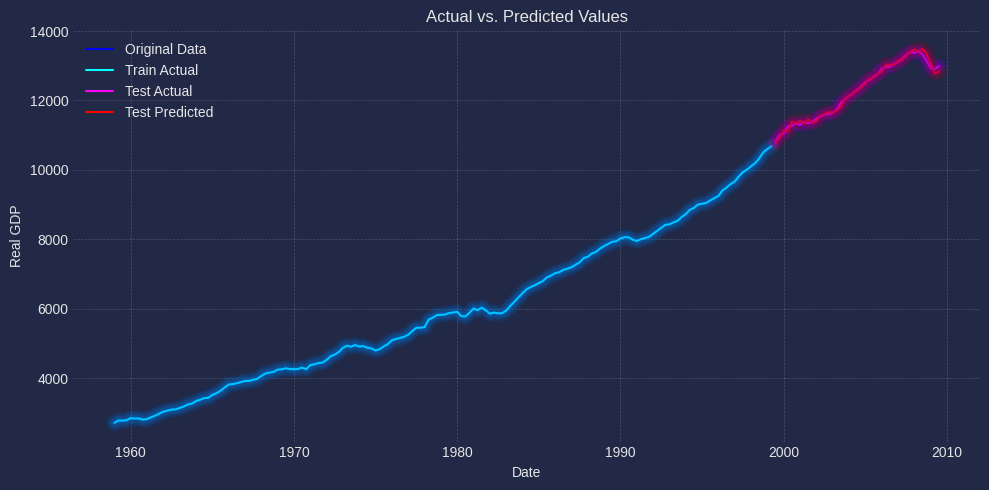


Test RMSE: 82.954
Test MAPE: 0.005


In [69]:
# Run the modeling process
arima_pred, arima_rmse, arima_mape = arima_model.run(time_series)

## XGBoost

In [70]:
# Perform time series forecasting with XGBoost model
class XGBoostTimeSeriesModel:
    def __init__(self, split_frac, lags=3, transform='none', scale=False, missing_data_strategy='drop'):
        self.split_frac = split_frac
        self.lags = lags
        self.transform = transform
        self.scale = scale
        self.missing_data_strategy = missing_data_strategy
        self.scaler = MinMaxScaler(feature_range=(0, 1)) if self.scale else None
        self.model = None

    def _apply_transforms(self, data_series):
        print("Applying transformations:", self.transform)
        if self.transform == 'log':
            data_series = np.log(data_series)
        elif self.transform == 'diff':
            data_series = data_series.diff()
        elif self.transform == 'log_diff':
            data_series = np.log(data_series).diff()

        if self.scale:
            print("Applying scaling")
            data_series = pd.Series(self.scaler.fit_transform(data_series.values.reshape(-1, 1)).flatten(),
                                    index=data_series.index)

        return data_series

    def _create_lags(self, data_series):
        print(f"Creating lags with {self.lags} periods")
        lagged_data = pd.concat([data_series.shift(i) for i in range(1, self.lags + 1)], axis=1)
        lagged_data.columns = [f'lag_{i}' for i in range(1, self.lags + 1)]
        lagged_data['target'] = data_series
        return lagged_data

    def _handle_missing_data(self, df):
        print(f"Handling missing data with strategy: {self.missing_data_strategy}")
        if self.missing_data_strategy == 'drop':
            df = df.dropna()
        elif self.missing_data_strategy == 'mean':
            df = df.fillna(df.mean())
        elif self.missing_data_strategy == 'ffill':
            df = df.fillna(method='ffill')
        elif self.missing_data_strategy == 'bfill':
            df = df.fillna(method='bfill')
        elif self.missing_data_strategy == 'iterative':
            imputer = IterativeImputer(max_iter=10, random_state=0)
            df[:] = imputer.fit_transform(df)

        return df

    def _inverse_transforms(self, series, original_data):
        if self.scale:
            series = pd.Series(self.scaler.inverse_transform(series.values.reshape(-1, 1))[:, 0],
                               index=series.index)

        if self.transform == 'diff':
            series = series.add(original_data.shift(1)).dropna()
        elif self.transform == 'log_diff':
            series = series.add(original_data.shift(1)).dropna()
            series = np.exp(series)
        elif self.transform == 'log':
            series = np.exp(series)

        return series

    def create_dataset(self, data_series):
        print("Applying transformations...")
        transformed_series = self._apply_transforms(data_series)

        # Create lags
        lagged_data = self._create_lags(transformed_series)

        # Handle missing data
        lagged_data = self._handle_missing_data(lagged_data)

        # Split the data
        print("Splitting data...")
        split_index = int(self.split_frac * len(lagged_data))
        train_lagged, test_lagged = lagged_data.iloc[:split_index], lagged_data.iloc[split_index:]

        return train_lagged, test_lagged, data_series.index[:split_index], data_series.index[split_index:], data_series[:split_index], data_series[split_index:]

    def build_model(self, X_train, y_train):
        print("\nBuilding XGBoost model...")
        dtrain = xgb.DMatrix(X_train, label=y_train)
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': 42
        }
        self.model = xgb.train(params, dtrain)

    def rolling_forecast(self, train, test, original_data):
        print("\nStarting rolling forecast...")
        predictions = []
        history = train.copy()

        X_train, y_train = history.drop(columns='target'), history['target']
        self.build_model(X_train, y_train)

        for t in range(len(test)):
            X_test = test.iloc[[t], :-1]
            dtest = xgb.DMatrix(X_test)
            yhat = self.model.predict(dtest)[0]

            predictions.append(yhat)
            obs = test['target'].iloc[t]

            # Update history with the observed value and new lags
            new_row = pd.Series(
                np.append(X_test.values[0][1:], obs),
                index=history.columns[:-1]
            )
            new_row['target'] = obs

            # Concatenate the new row to the history dataframe
            history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

            # Rebuild model with updated history
            X_train, y_train = history.drop(columns='target'), history['target']
            self.build_model(X_train, y_train)

            print(f"Observed: {obs}, Predicted: {yhat}")

        predictions = pd.Series(predictions, index=test.index)
        predictions = self._inverse_transforms(predictions, original_data)
        return predictions

    def plot_predictions(self, test_predict, original_data, train_actual, test_actual):
        # Convert PeriodIndex to DatetimeIndex for plotting
        if isinstance(train_actual.index, pd.PeriodIndex):
            train_actual = train_actual.to_timestamp()
        if isinstance(test_actual.index, pd.PeriodIndex):
            test_actual = test_actual.to_timestamp()
        if isinstance(test_predict.index, pd.PeriodIndex):
            test_predict = test_predict.to_timestamp()
        if isinstance(original_data.index, pd.PeriodIndex):
            original_data = original_data.to_timestamp()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        ax.plot(original_data, label='Original Data', color='blue')
        ax.plot(train_actual, label='Train Actual', color='cyan')
        ax.plot(test_actual, label='Test Actual', color='magenta')
        ax.plot(test_predict, label='Test Predicted', color='red')

        ax.legend()
        plt.title('Actual vs. Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Real GDP')
        plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
        plt.tight_layout()
        mcp.make_lines_glow()
        plt.show()

    def evaluate(self, y_true, y_pred):
        if y_pred.empty:
            return np.nan, np.nan
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    def run(self, data_series):
        print("Running the XGBoost model process...")
        train_data, test_data, train_dates, test_dates, train_actual, test_actual = self.create_dataset(data_series)

        # Rolling forecast
        try:
            test_predict = self.rolling_forecast(train_data, test_data, data_series)
        except ValueError as ve:
            print(f"Error during rolling forecast: {ve}")
            return None

        # Plot predictions
        print("\n")
        self.plot_predictions(test_predict, data_series, train_actual, test_actual)

        # Evaluate model performance
        test_rmse, test_mape = self.evaluate(test_actual, test_predict)

        print(f"\nTest RMSE: {test_rmse:.3f}")
        print(f"Test MAPE: {test_mape:.3f}")

        return test_predict, test_rmse, test_mape

In [71]:
# # Perform time series forecasting with XGBoost model
# class XGBoostTimeSeriesModel:
#     def __init__(self, split_frac, lags=3, transform='none', scale=False, missing_data_strategy='drop'):
#         self.split_frac = split_frac
#         self.lags = lags
#         self.transform = transform
#         self.scale = scale
#         self.missing_data_strategy = missing_data_strategy
#         self.scaler = MinMaxScaler(feature_range=(0, 1)) if self.scale else None
#         self.model = None

#     def _apply_transforms(self, data_series):
#         print("Applying transformations:", self.transform)
#         if self.transform == 'log':
#             data_series = np.log(data_series)
#         elif self.transform == 'diff':
#             data_series = data_series.diff()
#         elif self.transform == 'log_diff':
#             data_series = np.log(data_series).diff()

#         if self.scale:
#             print("Applying scaling")
#             data_series = pd.Series(self.scaler.fit_transform(data_series.values.reshape(-1, 1)).flatten(),
#                                     index=data_series.index)

#         return data_series

#     def _create_lags(self, data_series):
#         print(f"Creating lags with {self.lags} periods")
#         lagged_data = pd.concat([data_series.shift(i) for i in range(1, self.lags + 1)], axis=1)
#         lagged_data.columns = [f'lag_{i}' for i in range(1, self.lags + 1)]
#         lagged_data['target'] = data_series
#         return lagged_data

#     def _handle_missing_data(self, df):
#         print(f"Handling missing data with strategy: {self.missing_data_strategy}")
#         if self.missing_data_strategy == 'drop':
#             df = df.dropna()
#         elif self.missing_data_strategy == 'mean':
#             df = df.fillna(df.mean())
#         elif self.missing_data_strategy == 'ffill':
#             df = df.fillna(method='ffill')
#         elif self.missing_data_strategy == 'bfill':
#             df = df.fillna(method='bfill')
#         elif self.missing_data_strategy == 'iterative':
#             imputer = IterativeImputer(max_iter=10, random_state=0)
#             df[:] = imputer.fit_transform(df)

#         return df

#     def _inverse_transforms(self, series, original_data):
#         if self.scale:
#             series = pd.Series(self.scaler.inverse_transform(series.values.reshape(-1, 1))[:, 0],
#                                index=series.index)

#         if self.transform == 'diff':
#             series = series.add(original_data.shift(1)).dropna()
#         elif self.transform == 'log_diff':
#             series = series.add(original_data.shift(1)).dropna()
#             series = np.exp(series)
#         elif self.transform == 'log':
#             series = np.exp(series)

#         return series

#     def create_dataset(self, data_series):
#         print("Applying transformations...")
#         transformed_series = self._apply_transforms(data_series)

#         # Create lags
#         lagged_data = self._create_lags(transformed_series)

#         # Handle missing data
#         lagged_data = self._handle_missing_data(lagged_data)

#         # Split the data
#         print("Splitting data...")
#         split_index = int(self.split_frac * len(lagged_data))
#         train_lagged, test_lagged = lagged_data.iloc[:split_index], lagged_data.iloc[split_index:]

#         return train_lagged, test_lagged, data_series.index[:split_index], data_series.index[split_index:], data_series[:split_index], data_series[split_index:]

#     def build_model(self, X_train, y_train):
#         print("\nBuilding XGBoost model...")
#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         params = {
#             'objective': 'reg:squarederror',
#             'eval_metric': 'rmse',
#             'seed': 42
#         }
#         self.model = xgb.train(params, dtrain)

#     def rolling_forecast(self, train, test, original_data):
#         print("\nStarting rolling forecast...")
#         predictions = []
#         history = train.copy()

#         X_train, y_train = history.drop(columns='target'), history['target']
#         self.build_model(X_train, y_train)

#         for t in range(len(test)):
#             X_test = test.iloc[[t], :-1]
#             dtest = xgb.DMatrix(X_test)
#             yhat = self.model.predict(dtest)[0]

#             predictions.append(yhat)

#             # Update history with the predicted value and new lags
#             new_row = pd.Series(
#                 np.append(X_test.values[0][1:], yhat),
#                 index=history.columns[:-1]
#             )
#             new_row['target'] = yhat

#             # Concatenate the new row to the history dataframe
#             history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

#             # Rebuild model with updated history
#             X_train, y_train = history.drop(columns='target'), history['target']
#             self.build_model(X_train, y_train)

#             print(f"Predicted: {yhat}, Next input: {new_row['target']}")

#         predictions = pd.Series(predictions, index=test.index)
#         predictions = self._inverse_transforms(predictions, original_data)
#         return predictions

#     def plot_predictions(self, test_predict, original_data, train_actual, test_actual):
#         # Convert PeriodIndex to DatetimeIndex for plotting
#         if isinstance(train_actual.index, pd.PeriodIndex):
#             train_actual = train_actual.to_timestamp()
#         if isinstance(test_actual.index, pd.PeriodIndex):
#             test_actual = test_actual.to_timestamp()
#         if isinstance(test_predict.index, pd.PeriodIndex):
#             test_predict = test_predict.to_timestamp()
#         if isinstance(original_data.index, pd.PeriodIndex):
#             original_data = original_data.to_timestamp()

#         fig, ax = plt.subplots(figsize=(10, 5))
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#         ax.plot(original_data, label='Original Data', color='blue')
#         ax.plot(train_actual, label='Train Actual', color='cyan')
#         ax.plot(test_actual, label='Test Actual', color='magenta')
#         ax.plot(test_predict, label='Test Predicted', color='red')

#         ax.legend()
#         plt.title('Actual vs. Predicted Values')
#         plt.xlabel('Date')
#         plt.ylabel('Real GDP')
#         plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
#         plt.tight_layout()
#         mcp.make_lines_glow()
#         plt.show()

#     def evaluate(self, y_true, y_pred):
#         if y_pred.empty:
#             return np.nan, np.nan
#         rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#         mape = mean_absolute_percentage_error(y_true, y_pred)
#         return rmse, mape

#     def run(self, data_series):
#         print("Running the XGBoost model process...")
#         train_data, test_data, train_dates, test_dates, train_actual, test_actual = self.create_dataset(data_series)

#         # Rolling forecast
#         try:
#             test_predict = self.rolling_forecast(train_data, test_data, data_series)
#         except ValueError as ve:
#             print(f"Error during rolling forecast: {ve}")
#             return None

#         # Plot predictions
#         print("\n")
#         self.plot_predictions(test_predict, data_series, train_actual, test_actual)

#         # Evaluate model performance
#         test_rmse, test_mape = self.evaluate(test_actual, test_predict)

#         print(f"\nTest RMSE: {test_rmse:.3f}")
#         print(f"Test MAPE: {test_mape:.3f}")

#         return test_predict, test_rmse, test_mape

In [72]:
# Parameters for the XGBoost model
split_frac = 0.8                # 80% training, 20% testing
lags = 3                        # Number of lag features to create
transform = 'diff'              # Apply differencing transformation
scale = False                   # Scale the data
missing_data_strategy = 'mean'  # Fill missing data with the mean

In [73]:
# Initialize the modeling script
xgb_model = XGBoostTimeSeriesModel(
    split_frac=split_frac,
    lags=lags,
    transform=transform,
    scale=scale,
    missing_data_strategy=missing_data_strategy
)

Running the XGBoost model process...
Applying transformations...
Applying transformations: diff
Creating lags with 3 periods
Handling missing data with strategy: mean
Splitting data...

Starting rolling forecast...

Building XGBoost model...

Building XGBoost model...
Observed: 135.86499999999978, Predicted: 92.33499145507812

Building XGBoost model...
Observed: 194.34000000000015, Predicted: 119.11213684082031

Building XGBoost model...
Observed: 28.789999999999054, Predicted: 88.62344360351562

Building XGBoost model...
Observed: 215.40999999999985, Predicted: 37.72220993041992

Building XGBoost model...
Observed: 9.413000000000466, Predicted: 109.55370330810547

Building XGBoost model...
Observed: 66.67699999999968, Predicted: 27.768775939941406

Building XGBoost model...
Observed: -37.37299999999959, Predicted: -2.3395559787750244

Building XGBoost model...
Observed: 74.07999999999993, Predicted: 16.83418083190918

Building XGBoost model...
Observed: -31.175999999999476, Predicted:

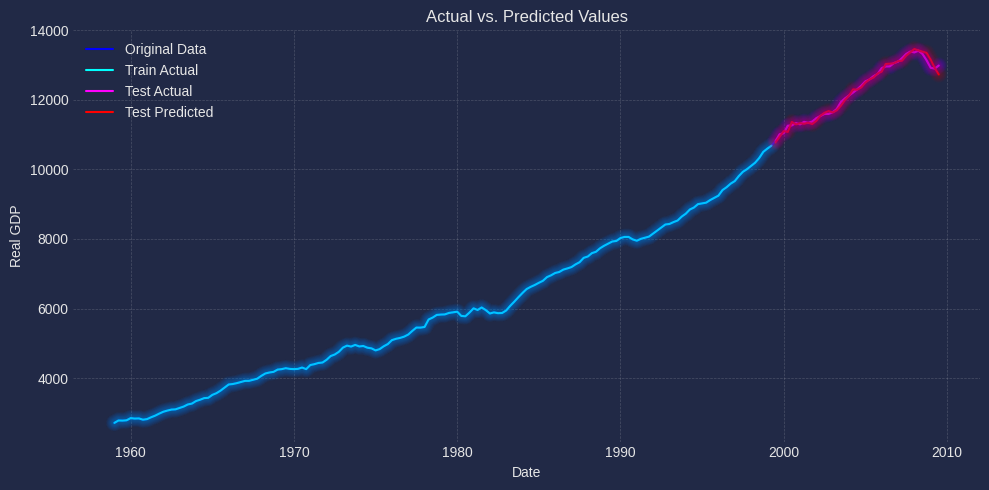


Test RMSE: 87.615
Test MAPE: 0.005


In [74]:
# Run the modeling process
xgb_pred, xgb_rmse, xgb_mape = xgb_model.run(time_series)

## Comparison

In [75]:
# Function to split the data
def split_data(time_series, split_frac=0.8):
    """
    Splits the time series data into training and test sets.

    Parameters:
    - time_series (pd.Series): The original full time series data.
    - split_frac (float): Fraction of data to use for training (default is 0.8).

    Returns:
    - train_data (pd.Series): Training data (first split_frac portion).
    - test_data (pd.Series): Test data (last 1-split_frac portion).
    - train_dates (pd.PeriodIndex): The dates corresponding to the training data.
    - test_dates (pd.PeriodIndex): The dates corresponding to the test data.
    """
    split_index = int(split_frac * len(time_series))
    train_data = time_series.iloc[:split_index]
    test_data = time_series.iloc[split_index:]
    train_dates = train_data.index
    test_dates = test_data.index

    return train_data, test_data, train_dates, test_dates

In [76]:
# Split the original full data
train_data, test_data, train_dates, test_dates = split_data(time_series)

# Display the split results
print(f"Training Data:\n{train_data.head()}\n")
print(f"Test Data:\n{test_data.head()}\n")
print(f"Training Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")

Training Data:
date
1959Q1    2710.349
1959Q2    2778.801
1959Q3    2775.488
1959Q4    2785.204
1960Q1    2847.699
Freq: Q-DEC, Name: realgdp, dtype: float64

Test Data:
date
1999Q3    10819.914
1999Q4    11014.254
2000Q1    11043.044
2000Q2    11258.454
2000Q3    11267.867
Freq: Q-DEC, Name: realgdp, dtype: float64

Training Data Length: 162
Test Data Length: 41


In [77]:
# Function to plot the predictions together
def compare_predictions(actual, lstm_pred, arima_pred, xgb_pred, test_dates):
    """
    Compares predictions from LSTM, ARIMA, and XGBoost models to the actual test data.

    Parameters:
    - actual (pd.Series): Actual test data.
    - lstm_pred (pd.Series): LSTM model predictions.
    - arima_pred (pd.Series): ARIMA model predictions.
    - xgb_pred (pd.Series): XGBoost model predictions.
    - test_dates (pd.PeriodIndex): The test period indices.

    Returns:
    - None
    """

    # Convert PeriodIndex to DatetimeIndex
    test_dates = test_dates.to_timestamp()

    # Convert actual data index to DatetimeIndex if it is not already
    if isinstance(actual.index, pd.PeriodIndex):
        actual.index = actual.index.to_timestamp()

    # Ensure predictions have the correct index
    lstm_pred.index = test_dates
    arima_pred.index = test_dates
    xgb_pred.index = test_dates

    # Slice the actual test data to match the length of the predictions
    actual = actual.loc[test_dates]

    # Create a DataFrame to hold all predictions and the actual data
    comparison_df = pd.DataFrame({
        'Actual': actual,
        'LSTM_Pred': lstm_pred,
        'ARIMA_Pred': arima_pred,
        'XGBoost_Pred': xgb_pred
    })

    # Drop NaN values if any are present
    comparison_df = comparison_df.dropna()

    # Print out the first few rows of the DataFrame
    print("Comparison DataFrame:\n", comparison_df.head())
    print("\n")

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    comparison_df.plot(ax=ax, style=['-', '--', ':', '-.'])
    ax.set_title('Actual vs. Predicted Values by LSTM, ARIMA, and XGBoost')
    ax.set_xlabel('Date')
    ax.set_ylabel('Real GDP')
    ax.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.2)
    plt.tight_layout()
    mcp.make_lines_glow()
    plt.show()

Comparison DataFrame:
                Actual     LSTM_Pred    ARIMA_Pred  XGBoost_Pred
date                                                           
1999-07-01  10819.914  10803.344891  10763.489989  10776.383991
1999-10-01  11014.254  10950.847838  10920.196292  10939.026137
2000-01-01  11043.044  11152.848543  11141.159614  11102.877444
2000-04-01  11258.454  11145.019449  11110.865480  11080.766210
2000-07-01  11267.867  11400.765188  11391.324097  11368.007703




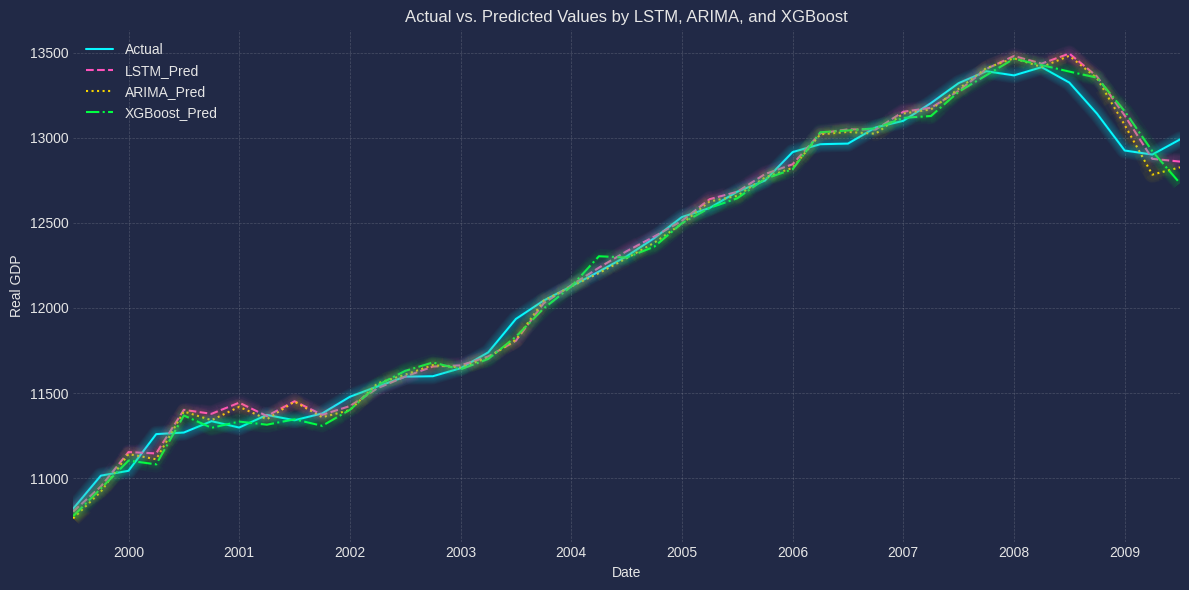

In [78]:
# Plot the results comparison
compare_predictions(test_data, lstm_pred, arima_pred, xgb_pred, test_dates)

In [79]:
# Create a dictionary of the forecasts
forecasts = {
    'LSTM': lstm_pred,
    'ARIMA': arima_pred,
    'XGBoost': xgb_pred
}

In [80]:
# Display comparison DataFrame
results_df = evaluate_forecasts(test_data, forecasts, sp=4, y_train=train_data)
display(results_df)

,MSE,RMSE,MAE,MASE,MAPE,sMAPE
Model,,,,,,
LSTM,6951.819,83.378,60.816,0.288,0.005,0.005
ARIMA,6881.402,82.954,63.121,0.299,0.005,0.005
XGBoost,7676.362,87.615,63.590,0.301,0.005,0.005


In [81]:
# Store RMSE values in a dictionary
rmse_scores = {
    'LSTM': lstm_rmse,
    'ARIMA': arima_rmse,
    'XGBoost': xgb_rmse
}

# Store MAPE values in a dictionary
mape_scores = {
    'LSTM': lstm_mape,
    'ARIMA': arima_mape,
    'XGBoost': xgb_mape
}

In [82]:
# Convert the RMSE dictionary to a DataFrame
rmse_df = pd.DataFrame(list(rmse_scores.items()), columns=['Model', 'RMSE'])

# Convert the MAPE dictionary to a DataFrame
mape_df = pd.DataFrame(list(mape_scores.items()), columns=['Model', 'MAPE'])

In [83]:
# Function to plot a bar chart
def plot_bar_chart(df, metric_name, color_map, title):
    """
    Plots a bar chart for the given metric with score values displayed above the bars.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the metric scores with columns ['Model', metric_name].
    - metric_name (str): The name of the metric (e.g., 'RMSE', 'MAPE').
    - color_map (dict): A dictionary mapping models to colors.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df['Model'], df[metric_name], color=[color_map[model] for model in df['Model']])

    # Add score values above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.6f}', ha='center', va='bottom', color='white')

    # Set y-axis limit
    plt.ylim(0, max(df[metric_name]) * 1.15)

    plt.title(title, color='white')
    plt.xlabel('Model', color='white')
    plt.ylabel(metric_name, color='white')
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.grid(True, color='#eeeeee', linestyle='--', linewidth=0.5, alpha=0.25)
    plt.show()

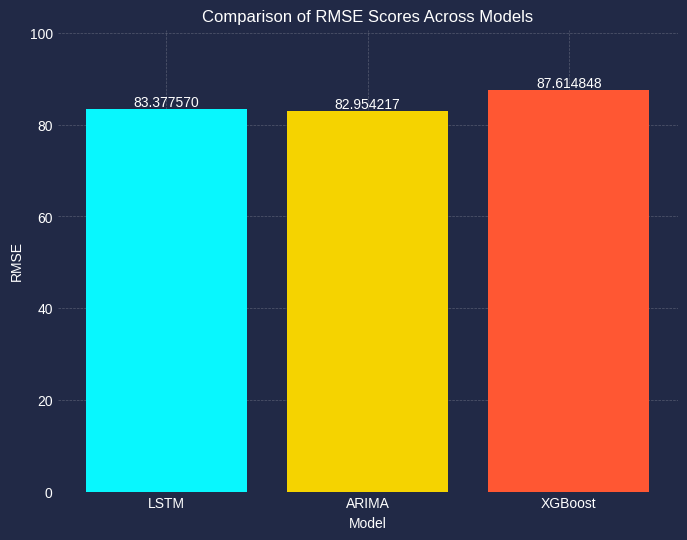

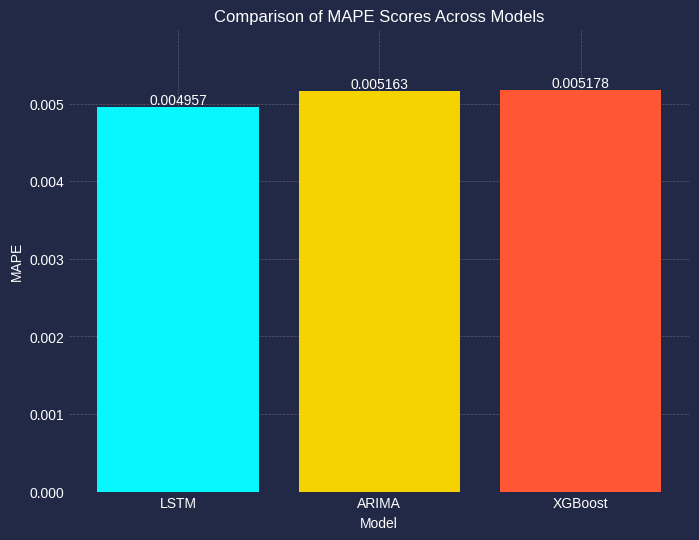

In [84]:
# Define a color map
color_map = {'LSTM': '#08F7FE', 'ARIMA': '#F5D300', 'XGBoost': '#FF5733'}

# Plot RMSE
plot_bar_chart(rmse_df, 'RMSE', color_map, 'Comparison of RMSE Scores Across Models')
print("\n")

# Plot MAPE
plot_bar_chart(mape_df, 'MAPE', color_map, 'Comparison of MAPE Scores Across Models')